In [1]:
# Set seed to ensure reproducible results are obtained

import os
os.environ["PYTHONHASHSEED"]=str(1)
import tensorflow as tf
tf.random.set_seed(1)
import numpy as np
np.random.seed(1)
import random
random.seed(1)

# Create function for implementing seed reset
def reset_random_seeds():
    os.environ["PYTHONHASHSEED"]=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

2024-09-01 17:43:07.102855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preparation

In [2]:
# Modules for data preparation, text preprocessing & text analysis

import pandas as pd
import numpy as np
import nltk
import re
import statistics
from scipy import stats
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

#nltk.download(["vader_lexicon"])
stop = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
analyser = SentimentIntensityAnalyzer()

# Remove warning
pd.options.mode.chained_assignment = None

In [3]:
# Create dataframes of results and submissions REF data
results = pd.read_excel("/Users/jessica/REF 2021 Results.xlsx")
subs = pd.read_excel("/Users/jessica/REF 2021 All Subs.xlsx")

In [4]:
# Drop irrelevant columns
results = results.drop(["Multiple submission letter", "Multiple submission name", "Joint submission", "FTE of submitted staff",
                        "Institution code (UKPRN)", "Institution sort order", "Profile",
                        "Total FTE of submitted staff for joint submission", "% of eligible staff submitted"],axis=1)

subs = subs.drop(["Institution UKPRN code","Multiple submission letter","Multiple submission name",
                 "Joint submission","REF impact case study identifier","Is continued from 2014",
                 "Countries","Formal partners","Funding programmes","Global research identifiers",
                 "Name of funders","Researcher ORCIDs","Grant funding"],axis=1)

In [5]:
# Drop any rows with no entries in the columns
results.dropna(inplace=True)
subs.dropna(inplace=True)

# Some results did not have percentages and had "-" instead
# Drop columns with "-"
results = results.drop(results[results["4*"] == "-"].index)

# Change values in ratings columns to be numeric type
results[["4*","3*","2*","1*","Unclassified"]] = results[["4*","3*","2*","1*","Unclassified"]].apply(pd.to_numeric)

# Change UoA number to be numeric integer to match data type of UoA in results dataframe
subs["Unit of assessment number"] = subs["Unit of assessment number"].astype(int)

In [6]:
# Merge columns that contain the contents of impact study
subs["Full Sub"] = subs[["Title","1. Summary of the impact","2. Underpinning research",
                      "3. References to the research","4. Details of the impact", 
                      "5. Sources to corroborate the impact"]].agg(''.join,axis=1)

In [7]:
# Merge submissions and results dataframes
merged = pd.merge(subs,results,on=["Institution name", "Unit of assessment number"], suffixes = ("", "_remove"))

# Drop any duplicate columns when merged
merged.drop([i for i in merged.columns if 'remove' in i],
               axis=1, inplace=True)

# Rename columns to shortened names
rename_cols = {'Institution name':'Name', 'Main panel':'Panel',
       'Unit of assessment number':'UoA Number', 'Unit of assessment name':'UoA Name',
       'Title':'Title', 'Summary impact type':'Sum Impact Type',
       '1. Summary of the impact':'Summary', '2. Underpinning research':'Research',
       '3. References to the research':'References', '4. Details of the impact':'Details',
       '5. Sources to corroborate the impact':'Sources'}
merged.rename(columns=rename_cols, inplace=True)

In [8]:
# Create sub dataframes
# 4* -> all submissions with 100% or greater 4*
# 3* -> all submissions with 100% or greater 3*
# 2*,1*,UC -> all submissions with 100% or greater 2*, 1* or Unclassified

ref4 = merged[(merged["4*"]>=100)]
ref3 = merged[merged["3*"]>=100]
ref2 = merged[(merged["2*"]>=100) | (merged["1*"]>=100) | (merged["Unclassified"]>=100)]

# Reset indexes
ref4.reset_index(drop=True,inplace=True)
ref3.reset_index(drop=True,inplace=True)
ref2.reset_index(drop=True,inplace=True)

# Text Preprocessing & Analysis

In [9]:
# Create function for calculating the number of references per submission

def calc_num_refs(row: int, text: str):
    line_num = 0
    num_refs = 0
    in_section = False
    notation_regex = ''
    references = []
    text = str(text)
    for line in text.splitlines():
        if line:
            line = line.lstrip(' -*#')
            line = line.replace('\\','')
            if re.match(r'^\s+$', line):
                continue # skip whitespace empty lines
            elif re.match(r'^nan$', line):
                continue # skip whitespace empty lines
            elif re.match(r'.*?Presentations.*', line) or re.match(r'^Presented.*', line) \
                or re.match(r'.*?Grants.*', line) or re.match(r'^Awards.*', line) \
                or re.match(r'^Reports.*', line) or re.match(r'^Funding.*', line):
                if in_section and num_refs:
                    break # we're done finding references
            if not in_section and re.match(r'.*?[Rr]eferences.*', line):
                in_section = True
            elif not in_section and (re.match(r'.*?[Pp]ublications.*', line) or re.match(r'.*[Pp]ublished.*', line)):
                in_section = True
            elif in_section or line_num == 0:
                found = False
                if num_refs == 0: # first ref so capture what notation is used
                    if (m := re.match(r'[\[^\(]?(\d\.?)[\]\)]?\S*\s+.*', line)):   # [1.] (1.) [1] (1) 1 1. 
                        ref = m.group(1)
                        notation_regex = '[\[^\(]?(\d\.?)[\]\)]?\S*\s+.*'
                        found = True
                    elif (m := re.match(r'[\[^\(]([A-Ea-e])[\]\)]\S*\s+.*', line)): #[a] (a) 
                        ref = m.group(1)
                        notation_regex = '[\[^\(]([A-Ea-e])[\]\)]\S*\s+.*'
                        found = True
                    elif (m := re.match(r'^([Rr]eference[\s-]\d)\S*\s+.*', line)): #Reference1 Reference-1 Reference 1 
                        ref = m.group(1)
                        notation_regex = '^([Rr]eference[\s-]\d)\S*\s+.*'
                        found = True
                    elif (m := re.match(r'.*?([Rr][Ee][Ff]\.?\s?\d)\S*\s+.*', line)): # Ref1 REF1 Ref 1
                        ref = m.group(1)
                        notation_regex = '.*?([Rr][Ee][Ff]\.?\s?\d)\S*\s+.*'
                        found = True
                    elif (m := re.match(r'.*?(R\d)[:\.]?\S*\s+.*', line)): # R1 R1: R1.
                        ref = m.group(1)
                        notation_regex = '.*?(R\d)[:\.]?\S*\s+.*'
                        found = True
                    elif (m := re.match(r'.*?(\d\.\d)\S*\s+.*', line)): # 3.1 3.2
                        ref = m.group(1)
                        notation_regex = '.*?(\d\.\d)\S*\s+.*'
                        found = True
                    elif (m := re.match(r'.*?(PUB\s?\d)\S*\s+.*', line)): # PUB1 PUB2 PUB3
                        ref = m.group(1)
                        notation_regex = '.*?(PUB\s?\d)\S*\s+.*'
                        found = True
                    elif (m := re.match(r'^(O\d)\S*\s+.*', line)): # O1 O2 O3
                        ref = m.group(1)
                        notation_regex = '^(O\d)\S*\s+.*'
                        found = True
                    if found:
                        references.append(ref)
                        num_refs += 1
                        in_section = True
                else:
                    if (m := re.match(r'{}'.format(notation_regex), line)):
                        ref = m.group(1)
                        references.append(line)
                        num_refs += 1
            else:
                sys.exit(-1)
        line_num += 1
    return num_refs

In [10]:
# Apply function to dataframes to calculate number of references
ref4["Num Refs"] = ref4.apply(lambda x: calc_num_refs(x.name, x["References"]), axis=1)
ref3["Num Refs"] = ref3.apply(lambda x: calc_num_refs(x.name, x["References"]), axis=1)
ref2["Num Refs"] = ref2.apply(lambda x: calc_num_refs(x.name, x["References"]), axis=1)

# Drop any rows with 0 number of references
ref4.drop(ref4.loc[ref4["Num Refs"]==0].index, inplace=True)
ref3.drop(ref3.loc[ref3["Num Refs"]==0].index, inplace=True)
ref2.drop(ref2.loc[ref2["Num Refs"]==0].index, inplace=True)

# Calculate mean number of references for each dataframe
ref4_mean_refs = np.mean(ref4["Num Refs"])
ref3_mean_refs = np.mean(ref3["Num Refs"])
ref2_mean_refs = np.mean(ref2["Num Refs"])

# Print out the averages
print("Average number of references for 4*:",ref4_mean_refs)
print("Average number of references for 3*:",ref3_mean_refs)
print("Average number of references for 2*:",ref2_mean_refs)

Average number of references for 4*: 5.478599221789883
Average number of references for 3*: 5.130841121495327
Average number of references for 2*: 5.2926829268292686


In [11]:
# Create function for calculating sentence length
def sentence_length(text):
    wordcounts = []
    sents = text.split(".")
    for sent in sents:
        words = sent.split(" ")
        wordcounts.append(len(words))
    avg_len = sum(wordcounts) / len(wordcounts)
    return avg_len

# Create list of columns of interest
cols = ["Full Sub","Title","Summary","Research","Details"]

# Create empty lists of sentence length means
ref4_means = []
ref3_means = []
ref2_means = []

# Calculate mean sentence length for each column in "cols" list and store in empty lists
for i in cols:
    r4 = np.mean(ref4[i].apply(lambda x: sentence_length(x)))
    ref4_means.append(r4)
    
    r3 = np.mean(ref3[i].apply(lambda x: sentence_length(x)))
    ref3_means.append(r3)
    
    r2 = np.mean(ref2[i].apply(lambda x: sentence_length(x)))
    ref2_means.append(r2)

# Print out sentence length means
print("Ref 4 mean sentence lengths:\n Full Sub:",ref4_means[0],
     "\n Title:",ref4_means[1],"\n Summary:",ref4_means[2],
      "\n Research:",ref4_means[3],"\n Details",ref4_means[4])

print("\nRef 3 mean sentence lengths:\n Full Sub:",ref3_means[0],
     "\n Title:",ref3_means[1],"\n Summary:",ref3_means[2],
      "\n Research:",ref3_means[3],"\n Details",ref3_means[4])

print("\nRef 2 mean sentence lengths:\n Full Sub:",ref2_means[0],
     "\n Title:",ref2_means[1],"\n Summary:",ref2_means[2],
      "\n Research:",ref2_means[3],"\n Details",ref2_means[4])    

Ref 4 mean sentence lengths:
 Full Sub: 14.73073414063679 
 Title: 12.600518806744489 
 Summary: 22.37286581008829 
 Research: 24.492295327272757 
 Details 24.09859633173484

Ref 3 mean sentence lengths:
 Full Sub: 15.198242493401409 
 Title: 12.649532710280374 
 Summary: 21.97336467992705 
 Research: 23.6580003017288 
 Details 24.048655102114846

Ref 2 mean sentence lengths:
 Full Sub: 16.118995455911996 
 Title: 10.609756097560975 
 Summary: 22.698096666604556 
 Research: 22.97783745072364 
 Details 24.702566729513507


In [12]:
# Create empty lists for variance values
ref4_var = []
ref3_var = []
ref2_var = []

# Create list of columns of interest
cols = ["Full Sub","Title","Summary","Research","Details"]

# Calculate variance of sentence length for each column in "cols" list and add to empty lists
for i in cols:
    r4 = statistics.variance(ref4[i].apply(lambda x: sentence_length(x)))
    ref4_var.append(r4)
    
    r3 = statistics.variance(ref3[i].apply(lambda x: sentence_length(x)))
    ref3_var.append(r3)
    
    r2 = statistics.variance(ref2[i].apply(lambda x: sentence_length(x)))
    ref2_var.append(r2)

# Print out variances
print("REF 4 Variance - Full Sub:",ref4_var[0])
print("REF 3 Variance - Full Sub:",ref3_var[0])
print("REF 2 Variance - Full Sub:",ref2_var[0])

print("\nREF 4 Variance - Title:",ref4_var[1])
print("REF 3 Variance - Title:",ref3_var[1])
print("REF 2 Variance - Title:",ref2_var[1])

#print("\nREF 4 Variance - Summary:",ref4_var[2])
#print("REF 3 Variance - Summary:",ref3_var[2])
#print("REF 2 Variance - Summary:",ref2_var[2])

#print("\nREF 4 Variance - Research:",ref4_var[3])
#print("REF 3 Variance - Research:",ref3_var[3])
#print("REF 2 Variance - Research:",ref2_var[3])

#print("\nREF 4 Variance - Details:",ref4_var[4])
#print("REF 3 Variance - Details:",ref3_var[4])
#print("REF 2 Variance - Details:",ref2_var[4])

REF 4 Variance - Full Sub: 16.53852186089397
REF 3 Variance - Full Sub: 19.31384466814612
REF 2 Variance - Full Sub: 14.645547025773984

REF 4 Variance - Title: 22.84934000756593
REF 3 Variance - Title: 19.618938458825603
REF 2 Variance - Title: 15.03140243902439


In [13]:
# Create list of average sentence length for each submission in ref4, ref3 and ref2 dataframes
ref4_fullsub_sl = ref4["Full Sub"].apply(lambda x: sentence_length(x)).tolist()
ref3_fullsub_sl = ref3["Full Sub"].apply(lambda x: sentence_length(x)).tolist()
ref2_fullsub_sl = ref2["Full Sub"].apply(lambda x: sentence_length(x)).tolist()

# Create list of title lengths in ref4, ref3 and ref2 dataframes
ref4_tit_sl = ref4["Title"].apply(lambda x: sentence_length(x)).tolist()
ref3_tit_sl = ref3["Title"].apply(lambda x: sentence_length(x)).tolist()
ref2_tit_sl = ref2["Title"].apply(lambda x: sentence_length(x)).tolist()

#ref4_sum_sl = ref4["Summary"].apply(lambda x: sentence_length(x)).tolist()
#ref3_sum_sl = ref3["Summary"].apply(lambda x: sentence_length(x)).tolist()
#ref2_sum_sl = ref2["Summary"].apply(lambda x: sentence_length(x)).tolist()

#ref4_res_sl = ref4["Research"].apply(lambda x: sentence_length(x)).tolist()
#ref3_res_sl = ref3["Research"].apply(lambda x: sentence_length(x)).tolist()
#ref2_res_sl = ref2["Research"].apply(lambda x: sentence_length(x)).tolist()

#ref4_dets_sl = ref4["Details"].apply(lambda x: sentence_length(x)).tolist()
#ref3_dets_sl = ref3["Details"].apply(lambda x: sentence_length(x)).tolist()
#ref2_dets_sl = ref2["Details"].apply(lambda x: sentence_length(x)).tolist()

# Conduct Welch's t-test to determine statistical significance
print("4* & 3* Full Sub Significance:",stats.ttest_ind(ref4_fullsub_sl,ref3_fullsub_sl,equal_var=False).pvalue)
print("4* & 2* Full Sub Significance:",stats.ttest_ind(ref4_fullsub_sl,ref2_fullsub_sl,equal_var=False).pvalue)
print("3* & 2* Full Sub Significance:",stats.ttest_ind(ref3_fullsub_sl,ref2_fullsub_sl,equal_var=False).pvalue)

print("\n4* & 3* Title Significance:",stats.ttest_ind(ref4_tit_sl,ref3_tit_sl,equal_var=False).pvalue)
print("4* & 2* Title Significance:",stats.ttest_ind(ref4_tit_sl,ref2_tit_sl,equal_var=False).pvalue)
print("3* & 2* Title Significance:",stats.ttest_ind(ref3_tit_sl,ref2_tit_sl,equal_var=False).pvalue)

#print("\n4* & 3* Summary Significance:",stats.ttest_ind(ref4_sum_sl,ref3_sum_sl,equal_var=False).pvalue)
#print("4* & 2* Summary Significance:",stats.ttest_ind(ref4_sum_sl,ref2_sum_sl,equal_var=False).pvalue)
#print("3* & 2* Summary Significance:",stats.ttest_ind(ref3_sum_sl,ref2_sum_sl,equal_var=False).pvalue)

#print("\n4* & 3* Research Significance:",stats.ttest_ind(ref4_res_sl,ref3_res_sl,equal_var=True).pvalue)
#print("4* & 2* Research Significance:",stats.ttest_ind(ref4_res_sl,ref2_res_sl,equal_var=True).pvalue)
#print("3* & 2* Research Significance:",stats.ttest_ind(ref3_res_sl,ref2_res_sl,equal_var=True).pvalue)

#print("\n4* & 3* Details Significance:",stats.ttest_ind(ref4_dets_sl,ref3_dets_sl,equal_var=False).pvalue)
#print("4* & 2* Details Significance:",stats.ttest_ind(ref4_dets_sl,ref2_dets_sl,equal_var=False).pvalue)
#print("3* & 2* Details Significance:",stats.ttest_ind(ref3_dets_sl,ref2_dets_sl,equal_var=False).pvalue)

4* & 3* Full Sub Significance: 0.34599726431619837
4* & 2* Full Sub Significance: 0.03692662460143678
3* & 2* Full Sub Significance: 0.21278037446554676

4* & 3* Title Significance: 0.9252494526674584
4* & 2* Title Significance: 0.00450249477897001
3* & 2* Title Significance: 0.007315778206435254


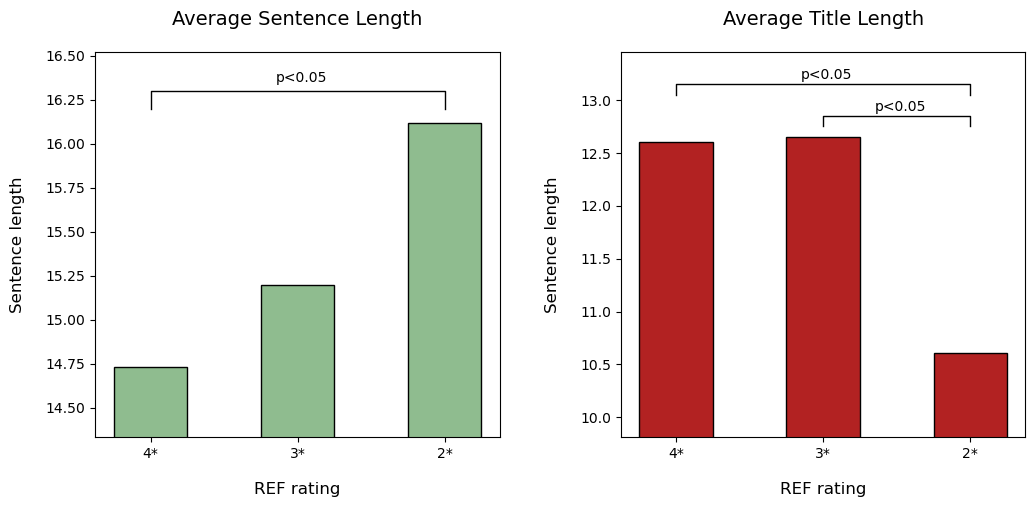

In [14]:
# Create lists of average sentence lengths and average title lengths
fullsub_sl = [ref4_means[0], ref3_means[0], ref2_means[0]]
title_sl = [ref4_means[1], ref3_means[1], ref2_means[1]]

# Create category labels
labels = ["4*", "3*", "2*"]
ind = np.arange(3)

# Create plot for sentence lengths
figs,axes = plt.subplots(1,2,sharex=False,sharey=False,
                         gridspec_kw={'wspace':0.3,
                                     'hspace':0.5},
                         figsize=(12,5))

# Configure plot for average sentence length per submission
axes[0].bar(ind,fullsub_sl,color="darkseagreen",width=0.5,
            edgecolor="black",linewidth=1,tick_label=labels)
axes[0].set_title("Average Sentence Length",fontsize=14,y=1.05)
axes[0].set_xlabel("REF rating",fontsize=12,labelpad=15)
axes[0].set_ylabel("Sentence length",fontsize=12,labelpad=15)
axes[0].set_ylim(min(fullsub_sl)-0.4,max(fullsub_sl)+0.4)

# Add statistical significance bar
axes[0].plot([0,0,2,2],[16.2,16.3,16.3,16.2],linewidth=1,color="black")
axes[0].text(0.85,16.35,"p<0.05",fontsize=10)

# Configure plot for average title length per submission
axes[1].bar(ind,title_sl,color="firebrick",width=0.5,
            edgecolor="black",linewidth=1,tick_label=labels)
axes[1].set_title("Average Title Length",fontsize=14,y=1.05)
axes[1].set_xlabel("REF rating",fontsize=12,labelpad=15)
axes[1].set_ylabel("Sentence length",fontsize=12,labelpad=15)
axes[1].set_ylim(min(title_sl)-0.8,max(title_sl)+0.8)

# Add statistical significance bars
axes[1].plot([0,0,2,2],[13.05,13.15,13.15,13.05],linewidth=1,color="black")
axes[1].text(0.85,13.20,"p<0.05",fontsize=10)
axes[1].plot([1,1,2,2],[12.75,12.85,12.85,12.75],linewidth=1,color="black")
axes[1].text(1.35,12.9,"p<0.05",fontsize=10)

plt.savefig("sentence_length.png")
plt.show()

In [15]:
# Text preprocessing:

# convert text to lowercase
ref4["Full Sub"] = ref4["Full Sub"].str.lower()
ref3["Full Sub"] = ref3["Full Sub"].str.lower()
ref2["Full Sub"] = ref2["Full Sub"].str.lower()

# remove HTML tags
ref4["Full Sub"] = ref4["Full Sub"].str.replace(r'<[^<>]*>',' ',regex=True)
ref3["Full Sub"] = ref3["Full Sub"].str.replace(r'<[^<>]*>',' ',regex=True)
ref2["Full Sub"] = ref2["Full Sub"].str.replace(r'<[^<>]*>',' ',regex=True)

# remove urls
ref4["Full Sub"] = ref4["Full Sub"].str.replace(r'\S*https?://\S+|www\.\S+',' ',regex=True)
ref3["Full Sub"] = ref3["Full Sub"].str.replace(r'\S*https?://\S+|www\.\S+',' ',regex=True)
ref2["Full Sub"] = ref2["Full Sub"].str.replace(r'\S*https?://\S+|www\.\S+',' ',regex=True)

# remove punctuation and numbers
ref4["Full Sub"] = ref4["Full Sub"].str.replace(r'[^a-zA-Z]',' ',regex=True)
ref3["Full Sub"] = ref3["Full Sub"].str.replace(r'[^a-zA-Z]',' ',regex=True)
ref2["Full Sub"] = ref2["Full Sub"].str.replace(r'[^a-zA-Z]',' ',regex=True)

# remove numbers
#ref4["Full Sub"] = ref4["Full Sub"].str.replace(r'\d+',' ',regex=True)
#ref3["Full Sub"] = ref3["Full Sub"].str.replace(r'\d+',' ',regex=True)
#ref2["Full Sub"] = ref2["Full Sub"].str.replace(r'\d+',' ',regex=True)

# remove extra white spaces
ref4["Full Sub"] = ref4["Full Sub"].str.replace(r'^\s*|\s\s*',' ',regex=True)
ref3["Full Sub"] = ref3["Full Sub"].str.replace(r'^\s*|\s\s*',' ',regex=True)
ref2["Full Sub"] = ref2["Full Sub"].str.replace(r'^\s*|\s\s*',' ',regex=True)

In [16]:
# Create function for calculating word length
def num_words(text):
    words = text.split(" ")
    return(len(words))

# Create list of columns of interest
cols = ["Full Sub","Summary","Research","Details"]

# Create empty lists of word length means
ref4_word_means = []
ref3_word_means = []
ref2_word_means = []

# Calculate mean number of words for each column in "cols" list and store in empty lists
for i in cols:
    r4 = np.mean(ref4[i].apply(lambda x: num_words(x)))
    ref4_word_means.append(r4)
    
    r3 = np.mean(ref3[i].apply(lambda x: num_words(x)))
    ref3_word_means.append(r3)
    
    r2 = np.mean(ref2[i].apply(lambda x: num_words(x)))
    ref2_word_means.append(r2)

# Print out mean number of words
print("Ref 4 mean word lengths:\n Full submission:",ref4_word_means[0],
     "\n Summary:",ref4_word_means[1],
      "\n Underpinning research",ref4_word_means[2],
      "\n Details",ref4_word_means[3])

print("\nRef 3 mean word lengths:\n Full submission:",ref3_word_means[0],
     "\n Summary:",ref3_word_means[1],
      "\n Underpinning research",ref3_word_means[2],
      "\n Details",ref3_word_means[3])

print("\nRef 2 mean word lengths:\n Full submission:",ref2_word_means[0],
     "\n Summary:",ref2_word_means[1],
      "\n Underpinning research",ref2_word_means[2],
      "\n Details",ref2_word_means[3])

Ref 4 mean word lengths:
 Full submission: 2671.817120622568 
 Summary: 150.61867704280155 
 Underpinning research 613.2023346303502 
 Details 1520.2762645914397

Ref 3 mean word lengths:
 Full submission: 2458.644859813084 
 Summary: 145.22429906542055 
 Underpinning research 620.3831775700935 
 Details 1314.6915887850466

Ref 2 mean word lengths:
 Full submission: 2112.048780487805 
 Summary: 139.4878048780488 
 Underpinning research 547.4634146341464 
 Details 1145.6829268292684


In [17]:
# Create empty lists for variance values
ref4_word_var = []
ref3_word_var = []
ref2_word_var = []

# Create list of columns of interest
columns = ["Full Sub","Summary","Research","Details"]

# Calculate variance of number of words for each column and store in empty lists
for i in columns:
    r4 = statistics.variance(ref4[i].apply(lambda x: num_words(x)))
    ref4_word_var.append(r4)
    
    r3 = statistics.variance(ref3[i].apply(lambda x: num_words(x)))
    ref3_word_var.append(r3)
    
    r2 = statistics.variance(ref2[i].apply(lambda x: num_words(x)))
    ref2_word_var.append(r2)

# Print out variances
print("REF 4 Variance - Full Sub:",ref4_word_var[0])
print("REF 3 Variance - Full Sub:",ref3_word_var[0])
print("REF 2 Variance - Full Sub:",ref2_word_var[0])

#print("\nREF 4 Variance - Summary:",ref4_word_var[1])
#print("REF 3 Variance - Summary:",ref3_word_var[1])
#print("REF 2 Variance - Summary:",ref2_word_var[1])

print("\nREF 4 Variance - Research:",ref4_word_var[2])
print("REF 3 Variance - Research:",ref3_word_var[2])
print("REF 2 Variance - Research:",ref2_word_var[2])

print("\nREF 2 Variance - Details:",ref4_word_var[3])
print("REF 2 Variance - Details:",ref3_word_var[3])
print("REF 2 Variance - Details:",ref2_word_var[3])

REF 4 Variance - Full Sub: 199393.1422057393
REF 3 Variance - Full Sub: 213728.1557044613
REF 2 Variance - Full Sub: 219942.4975609756

REF 4 Variance - Research: 22006.65421327821
REF 3 Variance - Research: 19960.483865279493
REF 2 Variance - Research: 14324.05487804878

REF 2 Variance - Details: 179876.32572349222
REF 2 Variance - Details: 151911.38511726327
REF 2 Variance - Details: 139233.5219512195


In [18]:
# Create list of average number of words for each submission in ref4, ref3 and ref2 dataframes
ref4_fullsub_word = ref4["Full Sub"].apply(lambda x: num_words(x)).tolist()
ref3_fullsub_word = ref3["Full Sub"].apply(lambda x: num_words(x)).tolist()
ref2_fullsub_word = ref2["Full Sub"].apply(lambda x: num_words(x)).tolist()

#ref4_sum_word = ref4["Summary"].apply(lambda x: num_words(x)).tolist()
#ref3_sum_word = ref3["Summary"].apply(lambda x: num_words(x)).tolist()
#ref2_sum_word = ref2["Summary"].apply(lambda x: num_words(x)).tolist()

#ref4_res_word = ref4["Research"].apply(lambda x: num_words(x)).tolist()
#ref3_res_word = ref3["Research"].apply(lambda x: num_words(x)).tolist()
#ref2_res_word = ref2["Research"].apply(lambda x: num_words(x)).tolist()

#ref4_dets_word = ref4["Details"].apply(lambda x: num_words(x)).tolist()
#ref3_dets_word = ref3["Details"].apply(lambda x: num_words(x)).tolist()
#ref2_dets_word = ref2["Details"].apply(lambda x: num_words(x)).tolist()

# Conduct Welch's t-test to determine statistical significance
print("4* & 3* Full Sub Significance:",stats.ttest_ind(ref4_fullsub_word,ref3_fullsub_word,equal_var=False).pvalue)
print("4* & 2* Full Sub Significance:",stats.ttest_ind(ref4_fullsub_word,ref2_fullsub_word,equal_var=False).pvalue)
print("3* & 2* Full Sub Significance:",stats.ttest_ind(ref3_fullsub_word,ref2_fullsub_word,equal_var=False).pvalue)

#print("\n4* & 3* Summary Significance:",stats.ttest_ind(ref4_sum_word,ref3_sum_word,equal_var=False).pvalue)
#print("4* & 2* Summary Significance:",stats.ttest_ind(ref4_sum_word,ref2_sum_word,equal_var=False).pvalue)
#print("3* & 2* Summary Significance:",stats.ttest_ind(ref3_sum_word,ref2_sum_word,equal_var=False).pvalue)

#print("\n4* & 3* Research Significance:",stats.ttest_ind(ref4_res_word,ref3_res_word,equal_var=False).pvalue)
#print("4* & 2* Research Significance:",stats.ttest_ind(ref4_res_word,ref2_res_word,equal_var=False).pvalue)
#print("3* & 2* Research Significance:",stats.ttest_ind(ref3_res_word,ref2_res_word,equal_var=False).pvalue)

#print("\n4* & 3* Details Significance:",stats.ttest_ind(ref4_dets_word,ref3_dets_word,equal_var=False).pvalue)
#print("4* & 2* Details Significance:",stats.ttest_ind(ref4_dets_word,ref2_dets_word,equal_var=False).pvalue)
#print("3* & 2* Details Significance:",stats.ttest_ind(ref3_dets_word,ref2_dets_word,equal_var=False).pvalue)

4* & 3* Full Sub Significance: 7.48412257524742e-05
4* & 2* Full Sub Significance: 2.854037996134065e-09
3* & 2* Full Sub Significance: 0.00013298015985258808


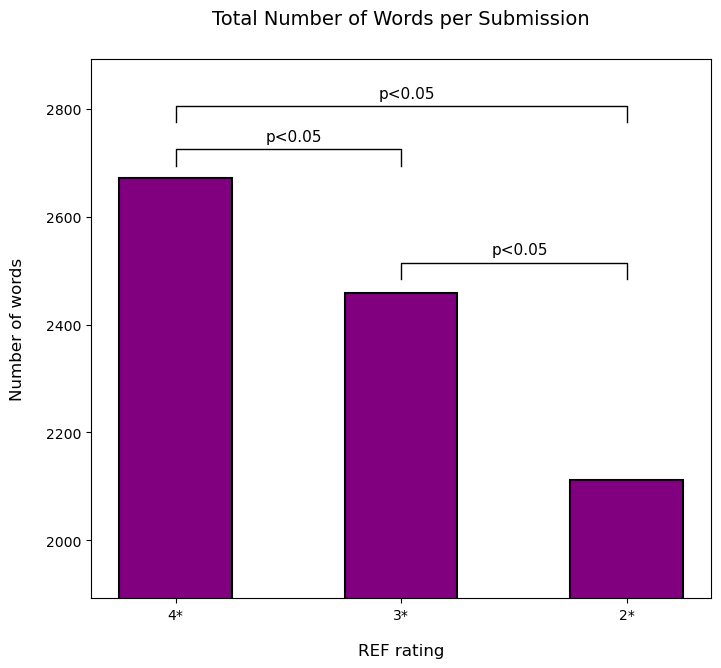

In [19]:
# Create lists of mean number of words for ref4, ref3 and ref2
fs_words = [ref4_word_means[0],ref3_word_means[0],
         ref2_word_means[0]]

# Create category labels
ind = np.arange(3)
labels = ["4*", "3*", "2*"]

# Create plot of number of words
fig = plt.figure(figsize=(8,7))
plt.bar(ind,fs_words,color="purple",edgecolor="black",
        width=0.5,linewidth=1.5,tick_label=labels)
plt.title("Total Number of Words per Submission",fontsize=14,y=1.05)
plt.xlabel("REF rating",fontsize=12,labelpad=15)
plt.ylabel("Number of words",fontsize=12,labelpad=15)
plt.ylim(min(fs_words)-220,max(fs_words)+220)

# Add statistical significance bars
plt.plot([0,0,2,2],[2775,2805,2805,2775],linewidth=1,color="black")
plt.text(0.9,2820,"p<0.05",fontsize=11)
plt.plot([0,0,1,1],[2695,2725,2725,2695],linewidth=1,color="black")
plt.text(0.4,2740,"p<0.05",fontsize=11)
plt.plot([1,1,2,2],[2485,2515,2515,2485],linewidth=1,color="black")
plt.text(1.4,2530,"p<0.05",fontsize=11)

plt.savefig("total_words.png")
plt.show()

In [8]:
# Create functions for pos-tagging & lemmatising sentences

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(sentence)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

In [21]:
# Columns of interest
cols = ["Full Sub","Title","Summary","Research","Details"]

# Word tokenise, stopword removal and lemmatisation of columns of interest
for i in cols:
    ref4[i] = ref4[i].apply(word_tokenize)
    ref4[i] = ref4[i].apply(lambda x: [item for item in x if item not in stop and len(item) > 1])
    ref4[i] = ref4[i].apply(lambda x: lemmatize_sentence(x))
    
    ref3[i] = ref3[i].apply(word_tokenize)
    ref3[i] = ref3[i].apply(lambda x: [item for item in x if item not in stop and len(item) > 1])
    ref3[i] = ref3[i].apply(lambda x: lemmatize_sentence(x))
    
    ref2[i] = ref2[i].apply(word_tokenize)
    ref2[i] = ref2[i].apply(lambda x: [item for item in x if item not in stop and len(item) > 1])
    ref2[i] = ref2[i].apply(lambda x: lemmatize_sentence(x))

In [22]:
# Create string version from tokenised version of full submissions

ref4["Full Sub Str"] = ref4["Full Sub"].apply(lambda x: " ".join(x))
ref3["Full Sub Str"] = ref3["Full Sub"].apply(lambda x: " ".join(x))
ref2["Full Sub Str"] = ref2["Full Sub"].apply(lambda x: " ".join(x))

In [23]:
# Create function for generating sentiment
def sentiment(text):
    scores = analyser.polarity_scores(text)
    compound = scores["compound"]
    return compound

# Create list of "compound" sentiment values for each submission
ref4_sentiments = ref4["Full Sub Str"].apply(lambda x: sentiment(x))
ref3_sentiments = ref3["Full Sub Str"].apply(lambda x: sentiment(x))
ref2_sentiments = ref2["Full Sub Str"].apply(lambda x: sentiment(x))

# Print out sentiment results
print("Average sentiment for 4*:",np.mean(ref4_sentiments))
print("Average sentiment for 3*:",np.mean(ref3_sentiments))
print("Average sentiment for 2*:",np.mean(ref2_sentiments))

Average sentiment for 4*: 0.8315677042801557
Average sentiment for 3*: 0.8532971962616823
Average sentiment for 2*: 0.6571365853658536


In [24]:
# Calculate variance of sentiment values
ref4_sent_var = statistics.variance(ref4_sentiments)
ref3_sent_var = statistics.variance(ref3_sentiments)
ref2_sent_var = statistics.variance(ref2_sentiments)

# Print out variance values
print("REF 4 Sentiment Variance:",ref4_sent_var)
print("REF 3 Sentiment Variance:",ref3_sent_var)
print("REF 2 Sentiment Variance:",ref2_sent_var)

REF 4 Sentiment Variance: 0.28273095797634973
REF 3 Sentiment Variance: 0.264013760463763
REF 2 Sentiment Variance: 0.5754718933780488


In [25]:
# Conduct Welch's t-test to determine statistical significance
print("4* & 3* Sentiment Significance:",stats.ttest_ind(ref4_sentiments,ref3_sentiments,equal_var=False).pvalue)
print("4* & 2* Sentiment Significance:",stats.ttest_ind(ref4_sentiments,ref2_sentiments,equal_var=False).pvalue)
print("3* & 2* Sentiment Significance:",stats.ttest_ind(ref3_sentiments,ref2_sentiments,equal_var=False).pvalue)

4* & 3* Sentiment Significance: 0.7163811739742053
4* & 2* Sentiment Significance: 0.16291697021497958
3* & 2* Sentiment Significance: 0.1325383423465669


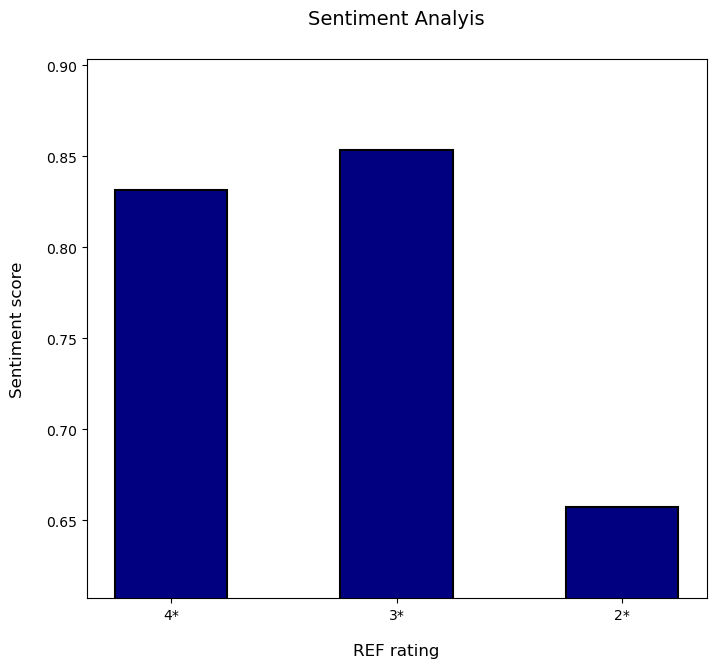

In [26]:
# Create list of sentiment scores
sentiment_scores = [np.mean(ref4_sentiments),np.mean(ref3_sentiments),
                    np.mean(ref2_sentiments)]

# Create category labels
ind = np.arange(3)
labels = ["4*", "3*", "2*"]

# Create plot of sentiment scores
fig = plt.figure(figsize=(8,7))
plt.bar(ind,sentiment_scores,color="navy",tick_label=labels,width=0.5,
        linewidth=1.5,edgecolor="black")
plt.title("Sentiment Analyis",fontsize=14,y=1.05)
plt.xlabel("REF rating",fontsize=12,labelpad=15)
plt.ylabel("Sentiment score",fontsize=12,labelpad=15)
plt.ylim(min(sentiment_scores)-0.05,max(sentiment_scores)+0.05)

plt.savefig("sentiment.png")
plt.show()

# Text Preprocessing for Model Configuration

In [9]:
# Create sub dataframes for modelling
# 4* -> all submissions with 70% or greater 4*
# 3* -> all submissions with 70% or greater 3*
# 2*,1*,UC -> all submissions with 70% or greater 2*, 1* or Unclassified

ref4 = merged[(merged["4*"]>=70)]
ref3 = merged[merged["3*"]>=70]
ref2 = merged[(merged["2*"]>=70) | (merged["1*"]>=70) | (merged["Unclassified"]>=70)]

# Reset indexes
ref4.reset_index(drop=True,inplace=True)
ref3.reset_index(drop=True,inplace=True)
ref2.reset_index(drop=True,inplace=True)

In [10]:
# Label encoding:
# 4* -> 2
# 3* -> 1
# 2*,1*,UC -> 0

# Insert encoded labels
ref4.insert(17,"REF score","2")
ref3.insert(17,"REF score","1")
ref2.insert(17,"REF score","0")

# Print the number of submissions for each REF score
print("No. of ref 4:",len(ref4))
print("No. of ref 3:",len(ref3))
print("No. of ref 2:",len(ref2))

No. of ref 4: 1525
No. of ref 3: 631
No. of ref 2: 236


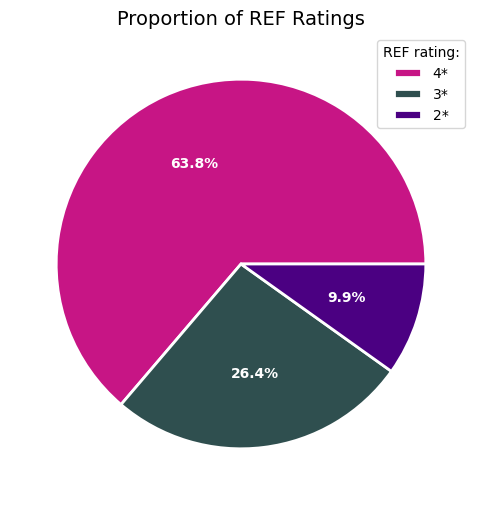

In [11]:
# Assign variables for number of submissions per REF score
ref4_len = len(ref4)
ref3_len = len(ref3)
ref2_len = len(ref2)

# Create array of dataframe lengths and corresponding labels
lengths = np.array([ref4_len, ref3_len, ref2_len])
labels = ["4*", "3*", "2*"]
colours = ["mediumvioletred", "darkslategray", "indigo"]

# Plot the number of submissions per REF score
fig,ax=plt.subplots(figsize=(6,6))

# Create pie chart, with percentages to show proportion 
patches,texts,pcts = ax.pie(lengths,labels=labels,labeldistance=None,
                            colors=colours,autopct="%1.1f%%",
                            wedgeprops={"linewidth":2.0,
                                        "edgecolor":"white"})
ax.set_title("Proportion of REF Ratings",fontsize=14,y=1)
ax.legend(title="REF rating:",loc="upper right")
plt.setp(pcts,color="white",fontweight="bold",fontsize=10)

plt.savefig("pie_chart.png")
plt.show()

In [12]:
# Concatenate dataframes and reset index
samples = pd.concat([ref4,ref3,ref2])
samples.reset_index(drop=True,inplace=True)

# Set "REF score" value as integer type
samples["REF score"] = samples["REF score"].astype(int)

In [13]:
# Text preprocessing:

# convert text to lowercase
samples["Full Sub"] = samples["Full Sub"].str.lower()

# remove HTML tags
samples["Full Sub"] = samples["Full Sub"].str.replace(r'<[^<>]*>',' ',regex=True)

# remove urls
samples["Full Sub"] = samples["Full Sub"].str.replace(r'https?://\S+|www\.\S+',' ',regex=True)

# remove punctuation and numbers
samples["Full Sub"] = samples["Full Sub"].str.replace(r'[^a-zA-Z]',' ',regex=True)

# remove extra white spaces
samples["Full Sub"] = samples["Full Sub"].str.replace(r'^\s*|\s\s*',' ',regex=True)

# word tokenisation
samples["Full Sub"] = samples["Full Sub"].apply(word_tokenize)

# stopword removal
samples["Full Sub"] = samples["Full Sub"].apply(lambda x: [item for item in x if item not in stop])

# lemmatisation
samples["Full Sub"] = samples["Full Sub"].apply(lambda x: lemmatize_sentence(x))

In [14]:
# Modules for modelling

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.model_selection import StratifiedKFold

import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

count = CountVectorizer()
sm = SMOTE(sampling_strategy="not majority",random_state=4,
          k_neighbors=5)

In [15]:
# Create X (text) and Y (scores) variables for modelling
sample_text = samples["Full Sub"].apply(lambda x: " ".join(x))
sample_scores = samples["REF score"]

# Convert text input into vectorised format
sample_text_vec = count.fit_transform(sample_text)

# Naive Bayes

In [34]:
# Set parameter values for "alpha" to test and create list
param_bayes = {"alpha": [0.01, 0.05, 0.1, 0.5, 0.8, 1]}
bayes_vals = [0.01, 0.05, 0.1, 0.5, 0.8, 1]

# Cross-validate to calculate the best parameter value 
bayes_ = MultinomialNB()
grid_bayes = GridSearchCV(bayes_,param_bayes,cv=10,scoring="accuracy")
grid_bayes.fit(sample_text_vec,sample_scores)

# Print the best parameter value and the subsequent accuracy score
print("Best alpha:",grid_bayes.best_params_)
print("Best score:",grid_bayes.best_score_)

# Create list of mean accuracy scores for each parameter value
bayes_scores = grid_bayes.cv_results_["mean_test_score"]

Best alpha: {'alpha': 1}
Best score: 0.5493357740585775


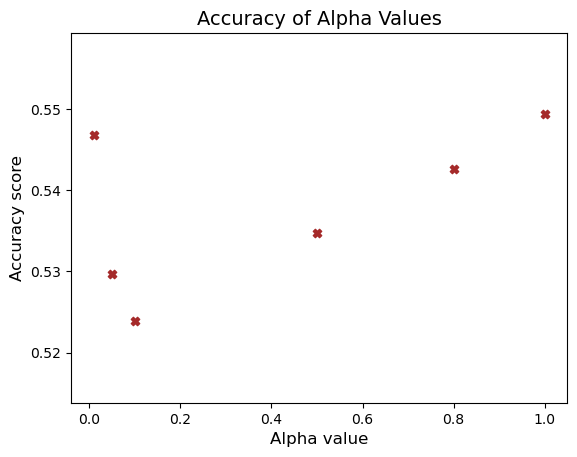

In [35]:
# Plot accuracy scores of alpha values
plt.scatter(bayes_vals,bayes_scores,color="brown",marker="X")
plt.xticks(np.arange(0,1.1,step=0.2))
plt.ylim(min(bayes_scores)-0.01,max(bayes_scores)+0.01)
plt.title("Accuracy of Alpha Values",fontsize=14,y=1)
plt.xlabel("Alpha value",fontsize=12)
plt.ylabel("Accuracy score",fontsize=12)

#plt.savefig("alpha_nb.png")
plt.show()

In [16]:
# Set classifier for cross-validation
skf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

# Create empty lists for metric scores
bayes_accuracy_scores = []
bayes_f1_scores = []
bayes_precision_scores = []
bayes_recall_scores = []

# Configure model using stratified cross-validation 
for train_index,test_index in skf.split(sample_text,sample_scores):
    X_train = sample_text[train_index]
    X_test = sample_text[test_index]
    y_train = sample_scores[train_index]
    y_test = sample_scores[test_index]
    
    # Convert text to vectorised format
    vect = CountVectorizer()
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Train model and predict using testing set
    bayes_ = MultinomialNB(alpha=1,force_alpha=True)
    bayes_.fit(X_train_vect,y_train)
    y_pred = bayes_.predict(X_test_vect)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred,average="macro",zero_division=0)
    precision = precision_score(y_test,y_pred,average="macro",zero_division=0)
    recall = recall_score(y_test,y_pred,average="macro")
    
    # Add metric scores to previously defined empty lists
    bayes_accuracy_scores.append(accuracy)
    bayes_f1_scores.append(f1)
    bayes_precision_scores.append(precision)
    bayes_recall_scores.append(recall)

In [17]:
# Print out mean metric scores to summarise model performance
print("Bayes Metrics:\n")
print("Average accuracy:",(np.mean(bayes_accuracy_scores)))
print("Average F1:",(np.mean(bayes_f1_scores)))
print("Average precision:",(np.mean(bayes_precision_scores)))
print("Average recall:",(np.mean(bayes_recall_scores)))

Bayes Metrics:

Average accuracy: 0.6296321478382148
Average F1: 0.46364576592148693
Average precision: 0.5397665573592907
Average recall: 0.4605897647642835


In [18]:
# Set classifier for cross-validation
skf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

# Create empty lists for metric scores
sm_bayes_accuracy_scores = []
sm_bayes_f1_scores = []
sm_bayes_precision_scores = []
sm_bayes_recall_scores = []

# Configure model using stratified cross-validation, with SMOTE 
for train_index,test_index in skf.split(sample_text,sample_scores):
    X_train = sample_text[train_index]
    X_test = sample_text[test_index]
    y_train = sample_scores[train_index]
    y_test = sample_scores[test_index]
    
    # Convert text to vectorised format
    vect = CountVectorizer()
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Implement SMOTE resampling
    sm = SMOTE(sampling_strategy="not majority",random_state=4,
          k_neighbors=5)
    res_text,res_scores = sm.fit_resample(X_train_vect,y_train)
    
    # Train model and predict using testing set
    bayes_ = MultinomialNB(alpha=1,force_alpha=True)
    bayes_.fit(res_text,res_scores)
    y_pred = bayes_.predict(X_test_vect)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred,average="macro",zero_division=0)
    precision = precision_score(y_test,y_pred,average="macro",zero_division=0)
    recall = recall_score(y_test,y_pred,average="macro")
    
    # Add metric scores to previously defined empty lists
    sm_bayes_accuracy_scores.append(accuracy)
    sm_bayes_f1_scores.append(f1)
    sm_bayes_precision_scores.append(precision)
    sm_bayes_recall_scores.append(recall)

In [19]:
# Print out mean metric scores to summarise model performance
print("Bayes Metrics:\n")
print("Average accuracy:",(np.mean(sm_bayes_accuracy_scores)))
print("Average F1:",(np.mean(sm_bayes_f1_scores)))
print("Average precision:",(np.mean(sm_bayes_precision_scores)))
print("Average recall:",(np.mean(sm_bayes_recall_scores)))

Bayes Metrics:

Average accuracy: 0.6384065550906556
Average F1: 0.48330589129569024
Average precision: 0.5188886084235684
Average recall: 0.47255790553572047


In [20]:
# Mean accuracy scores
print("Mean Naive Bayes accuracy scores:")
print(np.mean(bayes_accuracy_scores))
print(np.mean(sm_bayes_accuracy_scores),"\n")

# Conduct Shapiro-Wilk test for normality
print(stats.shapiro(bayes_accuracy_scores)) # normality assumed
print(stats.shapiro(sm_bayes_accuracy_scores)) # normality assumed

# Calculate variance of accuracy scores
print("\nVariance and t-test Naive Bayes accuracy scores:")
print(statistics.variance(bayes_accuracy_scores))
print(statistics.variance(sm_bayes_accuracy_scores),"\n")

# Conduct levene test to determine if variances are equal
print(stats.levene(bayes_accuracy_scores,
                        sm_bayes_accuracy_scores,
                        center="mean")) # equal variance assumed

# Conduct t-test for accuracy scores
nb_acc_ttest = stats.ttest_ind(bayes_accuracy_scores,sm_bayes_accuracy_scores,
                               equal_var=True,alternative="two-sided")
print("\nT-statistic:",nb_acc_ttest.statistic)
print("P-value:",nb_acc_ttest.pvalue,"\n")


# Mean F1 scores
print("\nMean Naive Bayes F1 scores:")
print(np.mean(bayes_f1_scores))
print(np.mean(sm_bayes_f1_scores),"\n")

# Conduct Shapiro-Wilk test for normality
print(stats.shapiro(bayes_f1_scores)) # normality assumed
print(stats.shapiro(sm_bayes_f1_scores)) # normality assumed

# Calculate variance of F1 scores
print("\nVariance and t-test Naive Bayes f1 scores:")
print(statistics.variance(bayes_f1_scores))
print(statistics.variance(sm_bayes_f1_scores),"\n")

# Conduct levene test to determine if variances are equal
print(stats.levene(bayes_f1_scores,
                        sm_bayes_f1_scores,
                        center="mean")) # equal variance assumed

# Conduct t-test for F1 scores
nb_f1_ttest = stats.ttest_ind(bayes_f1_scores,sm_bayes_f1_scores,
                              equal_var=True,alternative="two-sided")
print("\nT-statistic:",nb_f1_ttest.statistic)
print("P-value:",nb_f1_ttest.pvalue)

Mean Naive Bayes accuracy scores:
0.6296321478382148
0.6384065550906556 

ShapiroResult(statistic=0.8735527992248535, pvalue=0.10994281619787216)
ShapiroResult(statistic=0.9065627455711365, pvalue=0.25820520520210266)

Variance and t-test Naive Bayes accuracy scores:
0.0016518839130157082
0.0008581056463202104 

LeveneResult(statistic=0.5097642656117881, pvalue=0.48439711507867456)

T-statistic: -0.5538368267026836
P-value: 0.5865055207123318 


Mean Naive Bayes F1 scores:
0.46364576592148693
0.48330589129569024 

ShapiroResult(statistic=0.9131410717964172, pvalue=0.3032715618610382)
ShapiroResult(statistic=0.937434732913971, pvalue=0.5248382687568665)

Variance and t-test Naive Bayes f1 scores:
0.002476689441665361
0.0013515243299746843 

LeveneResult(statistic=2.070882796341466, pvalue=0.16729783754827685)

T-statistic: -1.0048198188433088
P-value: 0.32830120507621685


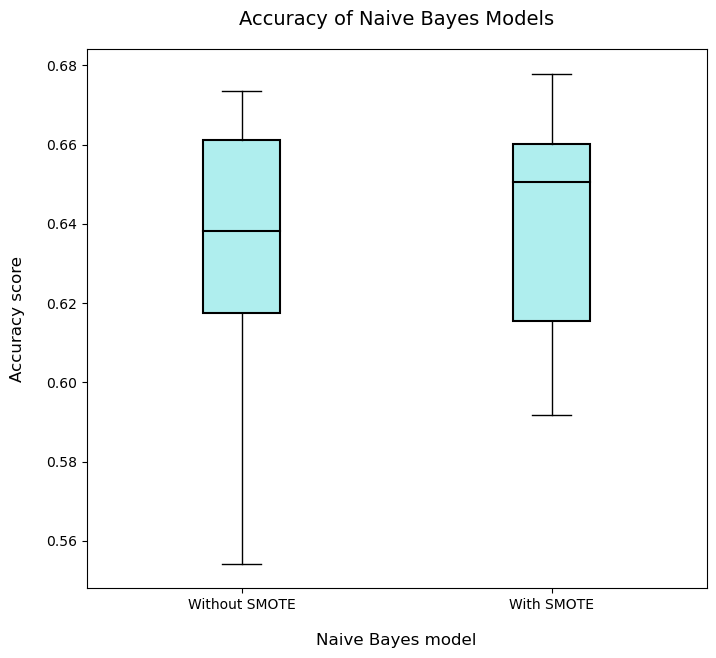

In [21]:
# Create plot for accuracy of model with and without SMOTE
fig = plt.figure(figsize=(8,7))
nb_acc_bplot = plt.boxplot([bayes_accuracy_scores,sm_bayes_accuracy_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"paleturquoise"},
                    medianprops={"linewidth":1.5})

for median in nb_acc_bplot["medians"]:
    median.set_color("black")

plt.title("Accuracy of Naive Bayes Models",
          fontsize=14,y=1.03)
plt.xlabel("Naive Bayes model",fontsize=12,labelpad=15)
plt.ylabel("Accuracy score",fontsize=12,labelpad=15)

plt.savefig("nb_accuracy_boxplot.png")
plt.show()

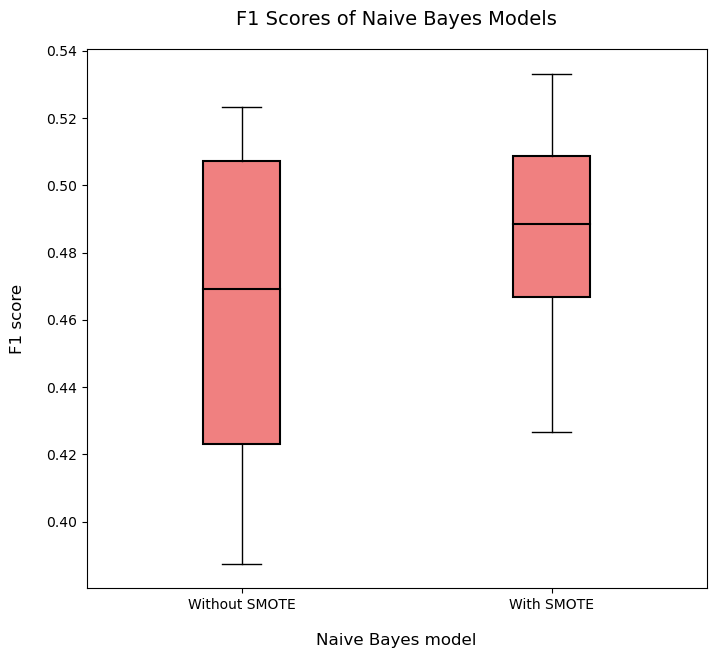

In [22]:
# Create plot for F1 of model with and without SMOTE
fig = plt.figure(figsize=(8,7))
nb_f1_bplot = plt.boxplot([bayes_f1_scores,sm_bayes_f1_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"lightcoral"},
                    medianprops={"linewidth":1.5})

for median in nb_f1_bplot["medians"]:
    median.set_color("black")

plt.title("F1 Scores of Naive Bayes Models",
          fontsize=14,y=1.03)
plt.xlabel("Naive Bayes model",fontsize=12,labelpad=15)
plt.ylabel("F1 score",fontsize=12,labelpad=15)

plt.savefig("nb_f1_boxplot.png")
plt.show()

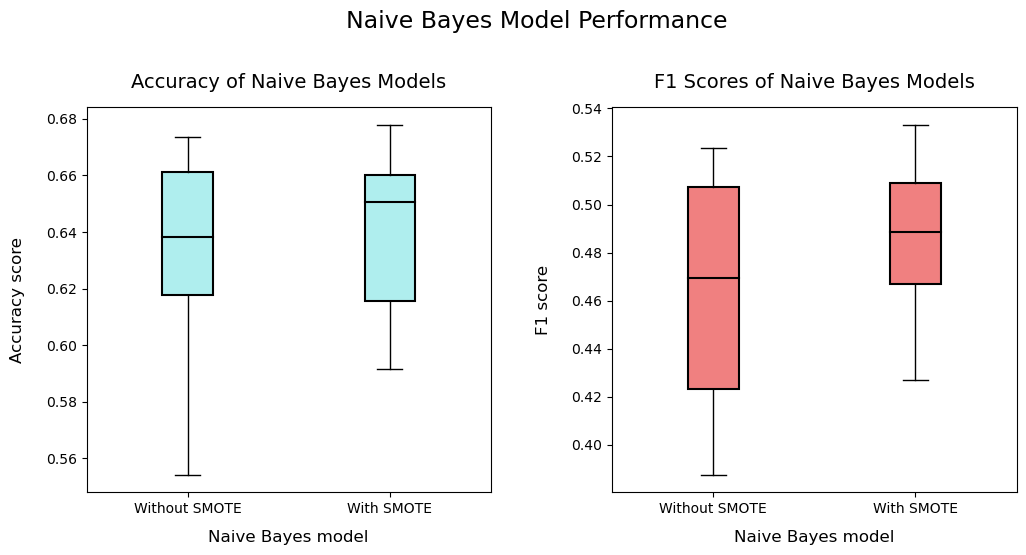

In [23]:
# Create plot for accuracy and F1 boxplots
figs,axes = plt.subplots(1,2,sharex=False,sharey=False,
                         gridspec_kw={'wspace':0.3,
                                     'hspace':0.5},
                         figsize=(12,5))
plt.suptitle("Naive Bayes Model Performance",fontsize=17,y=1.075)

# Plot accuracy scores
nb_acc_bplot = axes[0].boxplot([bayes_accuracy_scores,sm_bayes_accuracy_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"paleturquoise"},
                    medianprops={"linewidth":1.5})

for median in nb_acc_bplot["medians"]:
    median.set_color("black")

axes[0].set_title("Accuracy of Naive Bayes Models",fontsize=14,y=1.03)
axes[0].set_xlabel("Naive Bayes model",fontsize=12,labelpad=10)
axes[0].set_ylabel("Accuracy score",fontsize=12,labelpad=15)

# Plot F1 scores
nb_f1_bplot = axes[1].boxplot([bayes_f1_scores,sm_bayes_f1_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"lightcoral"},
                    medianprops={"linewidth":1.5})

for median in nb_f1_bplot["medians"]:
    median.set_color("black")

axes[1].set_title("F1 Scores of Naive Bayes Models",fontsize=14,y=1.03)
axes[1].set_xlabel("Naive Bayes model",fontsize=12,labelpad=10)
axes[1].set_ylabel("F1 score",fontsize=12,labelpad=15)

plt.savefig("nb_duo_bplot.png")
plt.show()

# XGBoost

In [44]:
# Set parameter values for "max depth" to test and create list
param_md = {"max_depth": [1, 3, 5, 7]}
md_vals = [1, 3, 5, 7]

# Cross-validate to calculate the best parameter value
xgb = XGBClassifier(objective="multi:softmax",num_class=3,
                   random_state=1)
grid_md = GridSearchCV(xgb,param_md,cv=5,scoring="accuracy")
grid_md.fit(sample_text_vec,sample_scores)

# Print the best parameter value and the subsequent accuracy score
print("Best max_depth:",grid_md.best_params_)
print("Best score:",grid_md.best_score_)

# Create list of mean accuracy scores for each parameter value
md_scores = grid_md.cv_results_["mean_test_score"]

Best max_depth: {'max_depth': 7}
Best score: 0.6429826783483723


In [45]:
# Set parameter values for "learning rate" to test and create list
param_lr = {"learning_rate": [0.3, 0.2, 0.1, 0.01]}
lr_vals = [0.3, 0.2, 0.1, 0.01]

# Cross-validate to calculate the best parameter value
xgb = XGBClassifier(objective="multi:softmax",num_class=3,
                   random_state=1)
grid_lr = GridSearchCV(xgb,param_lr,cv=5,scoring="accuracy")
grid_lr.fit(sample_text_vec,sample_scores)

# Print the best parameter value and the subsequent accuracy score
print("Best learning:",grid_lr.best_params_)
print("Best score:",grid_lr.best_score_)

# Create list of mean accuracy scores for each parameter value
lr_scores = grid_lr.cv_results_["mean_test_score"]

Best learning: {'learning_rate': 0.3}
Best score: 0.6475808212716521


In [46]:
# Set parameter values for "min child weight" to test and create list
param_mcw = {"min_child_weight": [1, 3, 5, 7]}
mcw_vals = [1, 3, 5, 7]

# Cross-validate to calculate the best parameter value
xgb = XGBClassifier(objective="multi:softmax",num_class=3,
                   random_state=1)
grid_mcw = GridSearchCV(xgb,param_mcw,cv=5,scoring="accuracy")
grid_mcw.fit(sample_text_vec,sample_scores)

# Print the best parameter value and the subsequent accuracy score
print("Best learning:",grid_mcw.best_params_)
print("Best score:",grid_mcw.best_score_)

# Create list of mean accuracy scores for each parameter value
mcw_scores = grid_mcw.cv_results_["mean_test_score"]

Best learning: {'min_child_weight': 1}
Best score: 0.6475808212716521


In [47]:
# Set parameter values for "gamma" to test and create list
param_gam = {"gamma": [0, 1, 2, 3]}
gam_vals = [0, 1, 2, 3]

# Cross-validate to calculate the best parameter value
xgb = XGBClassifier(objective="multi:softmax",num_class=3,
                   random_state=1)
grid_gam = GridSearchCV(xgb,param_gam,cv=5,scoring="accuracy")
grid_gam.fit(sample_text_vec,sample_scores)

# Print the best parameter value and the subsequent accuracy score
print("Best learning:",grid_gam.best_params_)
print("Best score:",grid_gam.best_score_)

# Create list of mean accuracy scores for each parameter value
gam_scores = grid_gam.cv_results_["mean_test_score"]

Best learning: {'gamma': 0}
Best score: 0.6475808212716521


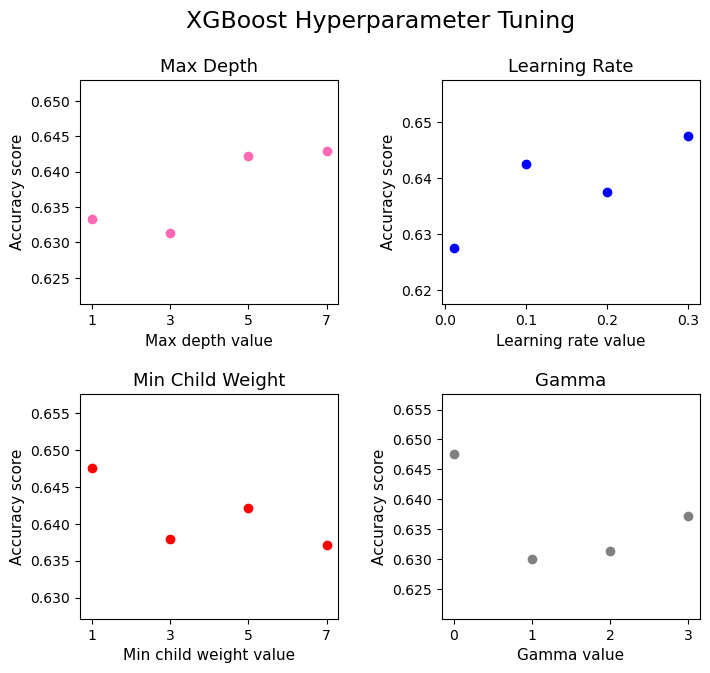

In [48]:
# Create plot for parameter hypertuning 
figs,axes = plt.subplots(2,2,sharex=False,sharey=False,
                         gridspec_kw={'wspace':0.4,
                                     'hspace':0.4},
                         figsize=(8,7))
plt.suptitle("XGBoost Hyperparameter Tuning",fontsize=17,y=0.98)

# Plot max depth values and accuracy scores
axes[0,0].scatter(md_vals,md_scores,color="hotpink",marker="o")
axes[0,0].set_xticks(np.arange(1,9,step=2))
axes[0,0].set_ylim(min(md_scores)-0.01,max(md_scores)+0.01)
axes[0,0].set_title("Max Depth",fontsize=13)
axes[0,0].set_xlabel("Max depth value",fontsize=11)
axes[0,0].set_ylabel("Accuracy score",fontsize=11)

# Plot learning rate values and accuracy scores
axes[0,1].scatter(lr_vals,lr_scores,color="blue",marker="o")
axes[0,1].set_xticks(np.arange(0,0.4,step=0.1))
axes[0,1].set_ylim(min(lr_scores)-0.01,max(lr_scores)+0.01)
axes[0,1].set_title("Learning Rate",fontsize=13)
axes[0,1].set_xlabel("Learning rate value",fontsize=11)
axes[0,1].set_ylabel("Accuracy score",fontsize=11)

# Plot min child weight values and accuracy scores
axes[1,0].scatter(mcw_vals,mcw_scores,color="red",marker="o")
axes[1,0].set_xticks(np.arange(1,9,step=2))
axes[1,0].set_ylim(min(mcw_scores)-0.01,max(mcw_scores)+0.01)
axes[1,0].set_title("Min Child Weight",fontsize=13)
axes[1,0].set_xlabel("Min child weight value",fontsize=11)
axes[1,0].set_ylabel("Accuracy score",fontsize=11)

# Plot gamma values and accuracy scores
axes[1,1].scatter(gam_vals,gam_scores,color="gray",marker="o")
axes[1,1].set_xticks(np.arange(0,4,step=1))
axes[1,1].set_ylim(min(gam_scores)-0.01,max(gam_scores)+0.01)
axes[1,1].set_title("Gamma",fontsize=13)
axes[1,1].set_xlabel("Gamma value",fontsize=11)
axes[1,1].set_ylabel("Accuracy score",fontsize=11)

plt.savefig("xgb_parameters.png")
plt.show()

In [24]:
# Set classifier for cross-validation
skf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

# Create empty lists for metric scores
xgb_accuracy_scores = []
xgb_f1_scores = []
xgb_precision_scores = []
xgb_recall_scores = []

# Configure model using stratified cross-validation
for train_index,test_index in skf.split(sample_text,sample_scores):
    X_train = sample_text[train_index]
    X_test = sample_text[test_index]
    y_train = sample_scores[train_index]
    y_test = sample_scores[test_index]
    
    # Compute sample weights to reflect imbalancef of samples per class
    sample_weights = compute_sample_weight(class_weight="balanced",
                                           y=y_train)
    
    # Convert text to vectorised format
    vect = CountVectorizer()
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Train model and predict using testing set
    xgb = XGBClassifier(objective="multi:softmax",num_class=3,
                        max_depth=7,learning_rate=0.3,
                        min_child_weight=1,gamma=0) 
    xgb.fit(X_train_vect,y_train,sample_weight=sample_weights)
    y_pred = xgb.predict(X_test_vect)
    
    # Calculate metricss
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred,average="macro",zero_division=0)
    precision = precision_score(y_test,y_pred,average="macro",zero_division=0)
    recall = recall_score(y_test,y_pred,average="macro")
    
    # Add metric scores to previously defined empty lists
    xgb_accuracy_scores.append(accuracy)
    xgb_f1_scores.append(f1)
    xgb_precision_scores.append(precision)
    xgb_recall_scores.append(recall)

In [25]:
# Print out mean metric scores to summarise model performance
print("XGB Metrics:\n")
print("Average accuracy:",(np.mean(xgb_accuracy_scores)))
print("Average F1:",(np.mean(xgb_f1_scores)))
print("Average precision:",(np.mean(xgb_precision_scores)))
print("Average recall:",(np.mean(xgb_recall_scores)))

XGB Metrics:

Average accuracy: 0.672670850767085
Average F1: 0.4978419536903741
Average precision: 0.5906219711627825
Average recall: 0.4770720637288732


In [26]:
# Set classifier for cross-validation
skf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

# Create empty lists for metric scores
sm_xgb_accuracy_scores = []
sm_xgb_f1_scores = []
sm_xgb_precision_scores = []
sm_xgb_recall_scores = []

# Configure model using stratified cross-validation, with SMOTE 
for train_index,test_index in skf.split(sample_text,sample_scores):
    X_train = sample_text[train_index]
    X_test = sample_text[test_index]
    y_train = sample_scores[train_index]
    y_test = sample_scores[test_index]
    
    # Convert text to vectorised format
    vect = CountVectorizer()
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Implement SMOTE resampling
    sm = SMOTE(sampling_strategy="not majority",random_state=4,
          k_neighbors=5)
    res_text,res_scores = sm.fit_resample(X_train_vect,y_train)
    
    # Compute sample weights to reflect imbalancef of samples per class
    sample_weights = compute_sample_weight(class_weight="balanced",
                                           y=res_scores)
    
    # Train model and predict using testing set
    xgb = XGBClassifier(objective="multi:softmax",num_class=3,
                        max_depth=7,learning_rate=0.3,
                        min_child_weight=1,gamma=0)
    xgb.fit(res_text,res_scores,sample_weight=sample_weights)
    y_pred = xgb.predict(X_test_vect)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred,average="macro",zero_division=0)
    precision = precision_score(y_test,y_pred,average="macro",zero_division=0)
    recall = recall_score(y_test,y_pred,average="macro")
    
    # Add metric scores to previously defined empty lists
    sm_xgb_accuracy_scores.append(accuracy)
    sm_xgb_f1_scores.append(f1)
    sm_xgb_precision_scores.append(precision)
    sm_xgb_recall_scores.append(recall)

In [27]:
# Print out mean metric scores to summarise model performance
print("XGB Metrics:\n")
print("Average accuracy:",(np.mean(sm_xgb_accuracy_scores)))
print("Average F1:",(np.mean(sm_xgb_f1_scores)))
print("Average precision:",(np.mean(sm_xgb_precision_scores)))
print("Average recall:",(np.mean(sm_xgb_recall_scores)))

XGB Metrics:

Average accuracy: 0.6714121338912133
Average F1: 0.4601232697043326
Average precision: 0.615579995848095
Average recall: 0.4456765481745711


In [28]:
# Mean accuracy scores
print("Mean XGB accuracy scores:")
print(np.mean(xgb_accuracy_scores))
print(np.mean(sm_xgb_accuracy_scores),"\n")

# Conduct Shapiro-Wilk test for normality
print(stats.shapiro(xgb_accuracy_scores))
print(stats.shapiro(sm_xgb_accuracy_scores))

# Calculate variance of accuracy scores
print("\nVariance and t-test XGB accuracy scores:")
print(statistics.variance(xgb_accuracy_scores))
print(statistics.variance(sm_xgb_accuracy_scores),"\n")

# Conduct levene test to determine if variances are equal
print(stats.levene(xgb_accuracy_scores,
                        sm_xgb_accuracy_scores,
                        center="mean"))

# Conduct t-test for accuracy scores
xgb_acc_ttest = stats.ttest_ind(xgb_accuracy_scores,sm_xgb_accuracy_scores,
                               equal_var=True,alternative="two-sided")
print("\nT-statistic:",xgb_acc_ttest.statistic)
print("P-value:",xgb_acc_ttest.pvalue)


# Mean F1 scores
print("\nMean XGB F1 scores:")
print(np.mean(xgb_f1_scores))
print(np.mean(sm_xgb_f1_scores),"\n")

# Conduct Shapiro-Wilk test for normality
print(stats.shapiro(xgb_f1_scores))
print(stats.shapiro(sm_xgb_f1_scores))

# Calculate variance of F1 scores
print("\nVariance and t-test XGB f1 scores:")
print(statistics.variance(xgb_f1_scores))
print(statistics.variance(sm_xgb_f1_scores),"\n")

# Conduct levene test to determine if variances are equal
print(stats.levene(xgb_f1_scores,
                        sm_xgb_f1_scores,
                        center="mean"))

# Conduct t-test for F1 scores
xgb_f1_ttest = stats.ttest_ind(xgb_f1_scores,sm_xgb_f1_scores,
                              equal_var=True,alternative="two-sided")
print("\nT-statistic:",xgb_f1_ttest.statistic)
print("P-value:",xgb_f1_ttest.pvalue)

Mean XGB accuracy scores:
0.672670850767085
0.6714121338912133 

ShapiroResult(statistic=0.8641034960746765, pvalue=0.08528277277946472)
ShapiroResult(statistic=0.9492005109786987, pvalue=0.6590501070022583)

Variance and t-test XGB accuracy scores:
0.0003097325776492224
0.00023979451461171575 

LeveneResult(statistic=0.5757591302880586, pvalue=0.45780107814809823)

T-statistic: 0.16979836367183251
P-value: 0.8670625109578975

Mean XGB F1 scores:
0.4978419536903741
0.4601232697043326 

ShapiroResult(statistic=0.8957343697547913, pvalue=0.19657103717327118)
ShapiroResult(statistic=0.9694174528121948, pvalue=0.8853923082351685)

Variance and t-test XGB f1 scores:
0.0004726271960694069
0.000688041080997901 

LeveneResult(statistic=0.14806201243177416, pvalue=0.7049029303136249)

T-statistic: 3.501083545670668
P-value: 0.002550583538752832


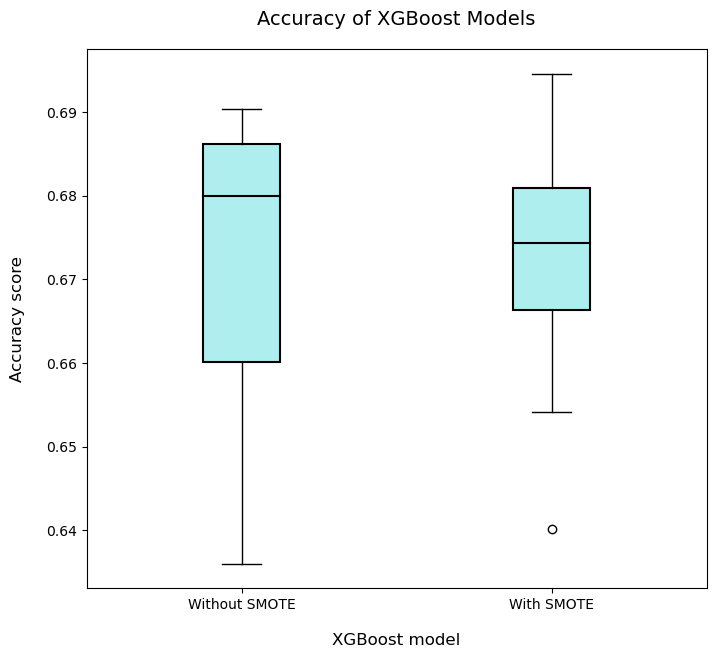

In [29]:
# Create plot for accuracy of model with and without SMOTE
fig = plt.figure(figsize=(8,7))
xgb_acc_bplot = plt.boxplot([xgb_accuracy_scores,sm_xgb_accuracy_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"paleturquoise"},
                    medianprops={"linewidth":1.5})

for median in xgb_acc_bplot["medians"]:
    median.set_color("black")

plt.title("Accuracy of XGBoost Models",fontsize=14,y=1.03)
plt.xlabel("XGBoost model",fontsize=12,labelpad=15)
plt.ylabel("Accuracy score",fontsize=12,labelpad=15)

plt.savefig("xgb_accuracy_boxplot.png")
plt.show()

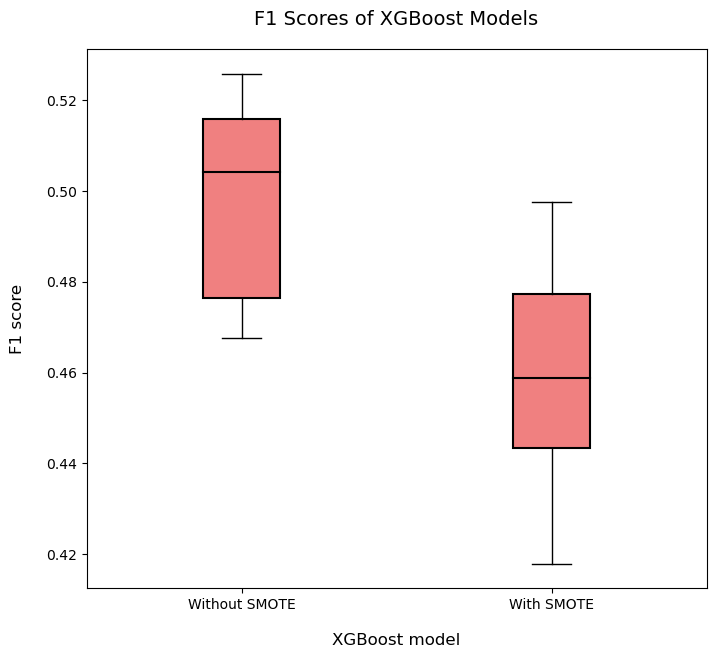

In [30]:
# Create plot for F1 of model with and without SMOTE
fig = plt.figure(figsize=(8,7))
xgb_f1_bplot = plt.boxplot([xgb_f1_scores,sm_xgb_f1_scores],
                           widths=0.25,patch_artist=True,
                           labels=["Without SMOTE","With SMOTE"],
                           boxprops={"linewidth":1.5,
                                    "facecolor":"lightcoral"},
                           medianprops={"linewidth":1.5})

for median in xgb_f1_bplot["medians"]:
    median.set_color("black")

plt.title("F1 Scores of XGBoost Models",fontsize=14,y=1.03)
plt.xlabel("XGBoost model",fontsize=12,labelpad=15)
plt.ylabel("F1 score",fontsize=12,labelpad=15)

plt.savefig("xgb_f1_boxplot.png")
plt.show()

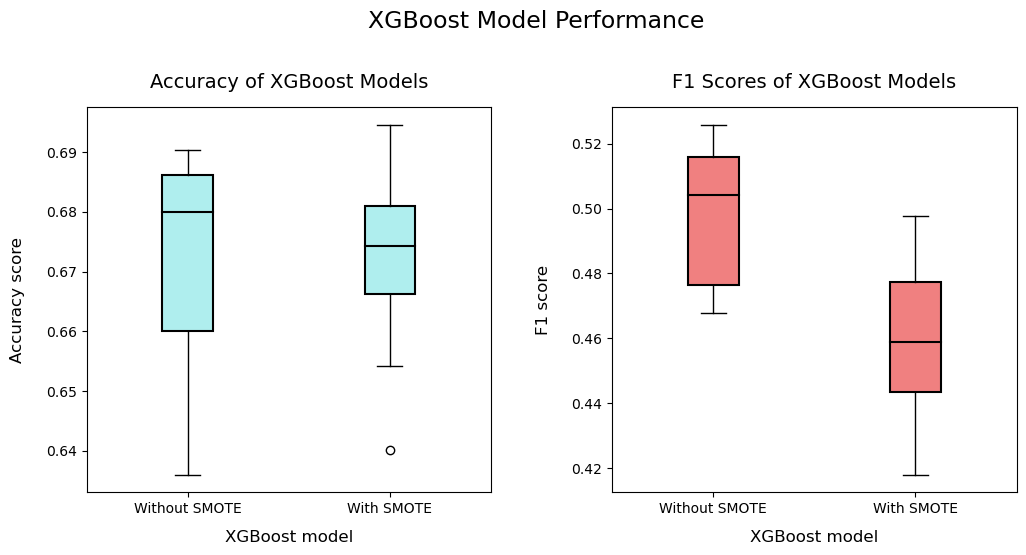

In [31]:
# Create plot for accuracy and F1 boxplots
figs,axes = plt.subplots(1,2,sharex=False,sharey=False,
                         gridspec_kw={'wspace':0.3,
                                     'hspace':0.5},
                         figsize=(12,5))
plt.suptitle("XGBoost Model Performance",fontsize=17,y=1.075)

# Plot accuracy scores
xgb_acc_bplot = axes[0].boxplot([xgb_accuracy_scores,sm_xgb_accuracy_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"paleturquoise"},
                    medianprops={"linewidth":1.5})

for median in xgb_acc_bplot["medians"]:
    median.set_color("black")

axes[0].set_title("Accuracy of XGBoost Models",fontsize=14,y=1.03)
axes[0].set_xlabel("XGBoost model",fontsize=12,labelpad=10)
axes[0].set_ylabel("Accuracy score",fontsize=12,labelpad=15)

# Plot F1 scores
xgb_f1_bplot = axes[1].boxplot([xgb_f1_scores,sm_xgb_f1_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"lightcoral"},
                    medianprops={"linewidth":1.5})

for median in xgb_f1_bplot["medians"]:
    median.set_color("black")

axes[1].set_title("F1 Scores of XGBoost Models",fontsize=14,y=1.03)
axes[1].set_xlabel("XGBoost model",fontsize=12,labelpad=10)
axes[1].set_ylabel("F1 score",fontsize=12,labelpad=15)

plt.savefig("xgb_duo_bplot.png")
plt.show()

# LSTM

In [32]:
# Modules for LSTM neural network
from sklearn.utils import class_weight
from sklearn import preprocessing
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

In [33]:
# Set parameters for LSTM
max_words = 10000 # max number of words
max_length = 500 # length of input
embedding_dim = 100 # output length for embedding layer
num_classes = 3 # number of classes
LSTM_units = 16 # LSTM units

# Set early stopping feature for neural network
early = EarlyStopping(monitor="val_accuracy",patience=3,
                     mode="auto")

# Create model layers
#LSTM_model = Sequential()
#LSTM_model.add(Embedding(max_words,embedding_dim,input_length=max_length))
#LSTM_model.add(Bidirectional(LSTM(LSTM_units,return_sequences=True)))
#LSTM_model.add(Bidirectional(LSTM(LSTM_units,go_backwards=True,dropout=0.2)))
#LSTM_model.add(Dense(num_classes,activation="softmax"))

# Configure model
#LSTM_model.compile(loss="sparse_categorical_crossentropy",
#             optimizer="adam",metrics=["accuracy"],
#             sample_weight_mode="temporal")
#LSTM_model.summary()

In [34]:
# Set classifier for cross-validation
skfold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

# Create empty lists for metric scores
lstm_accuracy_scores = []
lstm_f1_scores = []
lstm_precision_scores = []
lstm_recall_scores = []

# Configure model using stratified cross-validation
for train_index,test_index in skfold.split(sample_text,sample_scores):
    
    # Set random seed
    reset_random_seeds()
    
    # Create model and add layers
    LSTM_model = Sequential()
    LSTM_model.add(Embedding(max_words,embedding_dim,input_length=max_length))
    LSTM_model.add(Bidirectional(LSTM(LSTM_units,return_sequences=True)))
    LSTM_model.add(Bidirectional(LSTM(LSTM_units,go_backwards=True,dropout=0.2)))
    LSTM_model.add(Dense(num_classes,activation="softmax"))
    
    # Configure model
    LSTM_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"],
                       sample_weight_mode="temporal")
    
    # Training and testing data sets from stratified K-fold split
    X_train = sample_text[train_index]
    X_test = sample_text[test_index]
    y_train = sample_scores[train_index]
    y_test = sample_scores[test_index]
    
    # Compute class weights to reflect class imbalances in the data
    class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                 classes=np.unique(y_train),
                                                 y=y_train)
    # Create dictionary of class weights
    cw = dict(enumerate(class_weights))
    
    # Convert text to tokenised vector
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    train_sequences = tokenizer.texts_to_sequences(X_train)
    X_train = pad_sequences(train_sequences,maxlen=max_length)
    test_sequences = tokenizer.texts_to_sequences(X_test)
    X_test = pad_sequences(test_sequences,maxlen=max_length)

    # Train model and predict using testing set
    LSTM_model.fit(X_train,y_train,batch_size=32,
                   epochs=2,validation_split=0.1,
                   callbacks=[early],class_weight=cw)
    LSTM_pred_scores = []
    LSTM_pred = LSTM_model.predict(X_test)
    
    # LSTM outputs class probabilities, so predicted class = the class with the highest probability
    for i in range(0,len(LSTM_pred)):
        score = np.argmax(LSTM_pred[i])
        LSTM_pred_scores.append(score)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test,LSTM_pred_scores)
    f1 = f1_score(y_test,LSTM_pred_scores,average="macro",zero_division=0)
    precision = precision_score(y_test,LSTM_pred_scores,average="macro",zero_division=0)
    recall = recall_score(y_test,LSTM_pred_scores,average="macro")
    
    # Add metric scores to previously defined empty lists
    lstm_accuracy_scores.append(accuracy)
    lstm_f1_scores.append(f1)
    lstm_precision_scores.append(precision)
    lstm_recall_scores.append(recall)

Epoch 1/2
61/61 [==============================] - 29s 363ms/step - loss: 0.5919 - accuracy: 0.5201 - val_loss: 5.6690 - val_accuracy: 0.0000e+00
Epoch 2/2
8/8 [==============================] - 2s 98ms/step
Epoch 1/2
61/61 [==============================] - 37s 494ms/step - loss: 0.5914 - accuracy: 0.5046 - val_loss: 5.6115 - val_accuracy: 0.0000e+00
Epoch 2/2
8/8 [==============================] - 2s 106ms/step
Epoch 1/2
61/61 [==============================] - 37s 503ms/step - loss: 0.5948 - accuracy: 0.5049 - val_loss: 5.5744 - val_accuracy: 0.0139
Epoch 2/2
8/8 [==============================] - 2s 111ms/step
Epoch 1/2
61/61 [==============================] - 37s 497ms/step - loss: 0.5983 - accuracy: 0.4884 - val_loss: 5.6232 - val_accuracy: 0.0139
Epoch 2/2
8/8 [==============================] - 2s 107ms/step
Epoch 1/2
61/61 [==============================] - 36s 487ms/step - loss: 0.5956 - accuracy: 0.5111 - val_loss: 5.6206 - val_accuracy: 0.0139
Epoch 2/2
8/8 [================

In [35]:
# Print out mean metric scores to summarise model performance
print("LSTM Metrics:\n")
print("Average accuracy:",(np.mean(lstm_accuracy_scores)))
print("Average F1:",(np.mean(lstm_f1_scores)))
print("Average precision:",(np.mean(lstm_precision_scores)))
print("Average recall:",(np.mean(lstm_recall_scores)))

LSTM Metrics:

Average accuracy: 0.4924372384937238
Average F1: 0.3381340624635468
Average precision: 0.37780321408166123
Average recall: 0.40914899585565223


In [36]:
# Set classifier for cross-validation
skfold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

# Create empty lists for metric scores
sm_lstm_accuracy_scores = []
sm_lstm_f1_scores = []
sm_lstm_precision_scores = []
sm_lstm_recall_scores = []

# Configure model using stratified cross-validation, with SMOTE 
for train_index,test_index in skfold.split(sample_text,sample_scores):
    
    # Set random seed
    reset_random_seeds()
    
    # Create model and add layers
    LSTM_model = Sequential()
    LSTM_model.add(Embedding(max_words,embedding_dim,input_length=max_length))
    LSTM_model.add(Bidirectional(LSTM(LSTM_units,return_sequences=True)))
    LSTM_model.add(Bidirectional(LSTM(LSTM_units,go_backwards=True,dropout=0.2)))
    LSTM_model.add(Dense(num_classes,activation="softmax"))\
    
    # Configure model
    LSTM_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"],
                       sample_weight_mode="temporal")
    
    # Training and testing data sets from stratified K-fold split
    X_train = sample_text[train_index]
    X_test = sample_text[test_index]
    y_train = sample_scores[train_index]
    y_test = sample_scores[test_index]
    
    # Convert text to tokenised vector
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    train_sequences = tokenizer.texts_to_sequences(X_train)
    X_train = pad_sequences(train_sequences,maxlen=max_length)
    test_sequences = tokenizer.texts_to_sequences(X_test)
    X_test = pad_sequences(test_sequences,maxlen=max_length)
    
    # Implement SMOTE resampling
    sm = SMOTE(sampling_strategy="not majority",random_state=4,
          k_neighbors=5)
    res_text,res_scores = sm.fit_resample(X_train,y_train)
    
    # Compute class weights to reflect class imbalances in the data
    class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                 classes=np.unique(res_scores),
                                                 y=res_scores)
    # Create dictionary of class weights
    cw = dict(enumerate(class_weights))

    # Train model and predict using testing set
    LSTM_model.fit(res_text,res_scores,batch_size=32,
                   epochs=2,validation_split=0.1,
                   callbacks=[early],class_weight=cw)
    LSTM_pred_scores = []
    LSTM_pred = LSTM_model.predict(X_test)
    
    # LSTM outputs class probabilities, so predicted class = the class with the highest probability
    for i in range(0,len(LSTM_pred)):
        score = np.argmax(LSTM_pred[i])
        LSTM_pred_scores.append(score)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test,LSTM_pred_scores)
    f1 = f1_score(y_test,LSTM_pred_scores,average="macro",zero_division=0)
    precision = precision_score(y_test,LSTM_pred_scores,average="macro",zero_division=0)
    recall = recall_score(y_test,LSTM_pred_scores,average="macro")
    
    # Add metric scores to previously defined empty lists
    sm_lstm_accuracy_scores.append(accuracy)
    sm_lstm_f1_scores.append(f1)
    sm_lstm_precision_scores.append(precision)
    sm_lstm_recall_scores.append(recall)

Epoch 1/2
116/116 [==============================] - 53s 400ms/step - loss: 0.9093 - accuracy: 0.6115 - val_loss: 1.2698 - val_accuracy: 0.0000e+00
Epoch 2/2
8/8 [==============================] - 2s 107ms/step
Epoch 1/2
116/116 [==============================] - 65s 499ms/step - loss: 0.9024 - accuracy: 0.6104 - val_loss: 1.3206 - val_accuracy: 0.0121
Epoch 2/2
8/8 [==============================] - 2s 105ms/step
Epoch 1/2
116/116 [==============================] - 63s 488ms/step - loss: 0.8932 - accuracy: 0.6242 - val_loss: 1.4540 - val_accuracy: 0.0049
Epoch 2/2
8/8 [==============================] - 2s 105ms/step
Epoch 1/2
116/116 [==============================] - 63s 477ms/step - loss: 0.9128 - accuracy: 0.6004 - val_loss: 1.4633 - val_accuracy: 0.0000e+00
Epoch 2/2
8/8 [==============================] - 3s 202ms/step
Epoch 1/2
116/116 [==============================] - 60s 462ms/step - loss: 0.9055 - accuracy: 0.6058 - val_loss: 1.4926 - val_accuracy: 0.0218
Epoch 2/2
8/8 [=====

In [37]:
# Print out mean metric scores to summarise model performance
print("LSTM Metrics:\n")
print("Average accuracy:",(np.mean(sm_lstm_accuracy_scores)))
print("Average F1:",(np.mean(sm_lstm_f1_scores)))
print("Average precision:",(np.mean(sm_lstm_precision_scores)))
print("Average recall:",(np.mean(sm_lstm_recall_scores)))

LSTM Metrics:

Average accuracy: 0.6020153417015341
Average F1: 0.4138318265020162
Average precision: 0.4344811526387602
Average recall: 0.42777738717531255


In [38]:
# Mean accuracy scores
print("\nMean LSTM accuracy scores:")
print(np.mean(lstm_accuracy_scores))
print(np.mean(sm_lstm_accuracy_scores),"\n")

# Conduct Shapiro-Wilk test for normality
print(stats.shapiro(lstm_accuracy_scores))
print(stats.shapiro(sm_lstm_accuracy_scores))

# Calculate variance of accuracy scores
print("\nVariance and t-test LSTM accuracy scores:")
print(statistics.variance(lstm_accuracy_scores))
print(statistics.variance(sm_lstm_accuracy_scores),"\n")

# Conduct levene test to determine if variances are equal
print(stats.levene(lstm_accuracy_scores,
                        sm_lstm_accuracy_scores,
                        center="mean"))

# Conduct t-test for accuracy scores
lstm_acc_ttest = stats.ttest_ind(lstm_accuracy_scores,sm_lstm_accuracy_scores,
                               equal_var=True,alternative="two-sided")
print("\nT-statistic:",lstm_acc_ttest.statistic)
print("P-value:",lstm_acc_ttest.pvalue,"\n")


# Mean F1 scores
print("\nMean LSTM F1 scores:")
print(np.mean(lstm_f1_scores))
print(np.mean(sm_lstm_f1_scores),"\n")

# Conduct Shapiro-Wilk test for normality
print(stats.shapiro(lstm_f1_scores)) 
print(stats.shapiro(sm_lstm_f1_scores)) 

# Calculate variance of F1 scores
print("\nVariance and t-test LSTM f1 scores:")
print(statistics.variance(lstm_f1_scores))
print(statistics.variance(sm_lstm_f1_scores),"\n")

# Conduct levene test to determine if variances are equal
print(stats.levene(lstm_f1_scores,
                        sm_lstm_f1_scores,
                        center="mean")) # equal variance assumed

# Conduct t-test for F1 scores
lstm_f1_ttest = stats.ttest_ind(lstm_f1_scores,sm_lstm_f1_scores,
                              equal_var=True,alternative="two-sided")
print("\nT-statistic:",lstm_f1_ttest.statistic)
print("P-value:",lstm_f1_ttest.pvalue)


Mean LSTM accuracy scores:
0.4924372384937238
0.6020153417015341 

ShapiroResult(statistic=0.9059799313545227, pvalue=0.25450238585472107)
ShapiroResult(statistic=0.973363995552063, pvalue=0.920162558555603)

Variance and t-test LSTM accuracy scores:
0.003780603069485807
0.0007883721387628304 

LeveneResult(statistic=9.865413565655025, pvalue=0.005649631983595921)

T-statistic: -5.126422282528822
P-value: 7.067408690193033e-05 


Mean LSTM F1 scores:
0.3381340624635468
0.4138318265020162 

ShapiroResult(statistic=0.871671736240387, pvalue=0.10454816371202469)
ShapiroResult(statistic=0.9417388439178467, pvalue=0.5725197792053223)

Variance and t-test LSTM f1 scores:
0.0015137265844195412
0.0006760373289206332 

LeveneResult(statistic=3.689110564743174, pvalue=0.07075365070329008)

T-statistic: -5.115456598190162
P-value: 7.236177967643647e-05


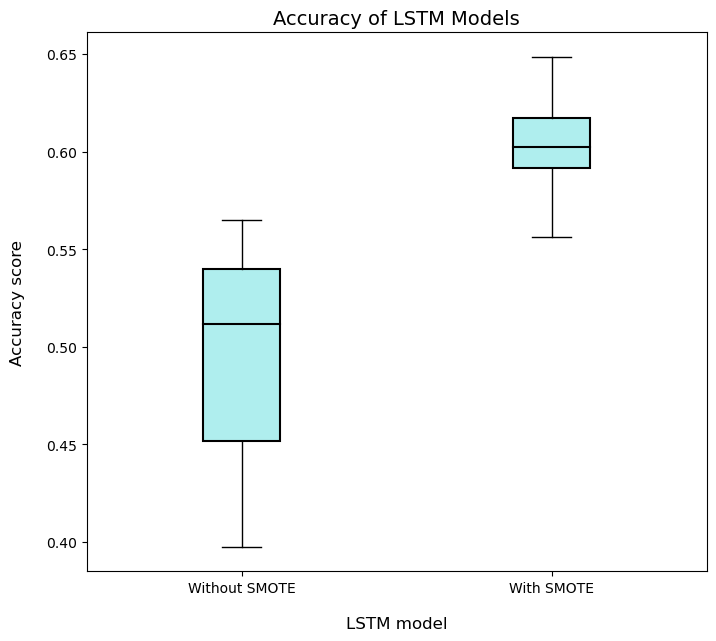

In [39]:
# Create plot for accuracy of model with and without SMOTE
fig = plt.figure(figsize=(8,7))
lstm_acc_bplot = plt.boxplot([lstm_accuracy_scores,sm_lstm_accuracy_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"paleturquoise"},
                    medianprops={"linewidth":1.5})

for median in lstm_acc_bplot["medians"]:
    median.set_color("black")

plt.title("Accuracy of LSTM Models",fontsize=14,y=1)
plt.xlabel("LSTM model",fontsize=12,labelpad=15)
plt.ylabel("Accuracy score",fontsize=12,labelpad=15)

plt.savefig("lstm_accuracy_boxplot.png")
plt.show()

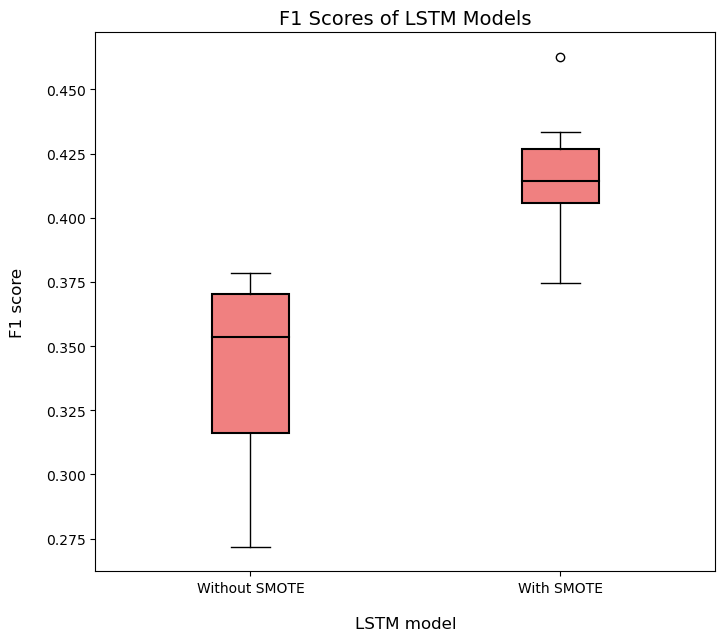

In [40]:
# Create plot for F1 of model with and without SMOTE
fig = plt.figure(figsize=(8,7))
lstm_f1_bplot = plt.boxplot([lstm_f1_scores,sm_lstm_f1_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"lightcoral"},
                    medianprops={"linewidth":1.5})

for median in lstm_f1_bplot["medians"]:
    median.set_color("black")

plt.title("F1 Scores of LSTM Models",fontsize=14,y=1)
plt.xlabel("LSTM model",fontsize=12,labelpad=15)
plt.ylabel("F1 score",fontsize=12,labelpad=15)

plt.savefig("lstm_f1_boxplot.png")
plt.show()

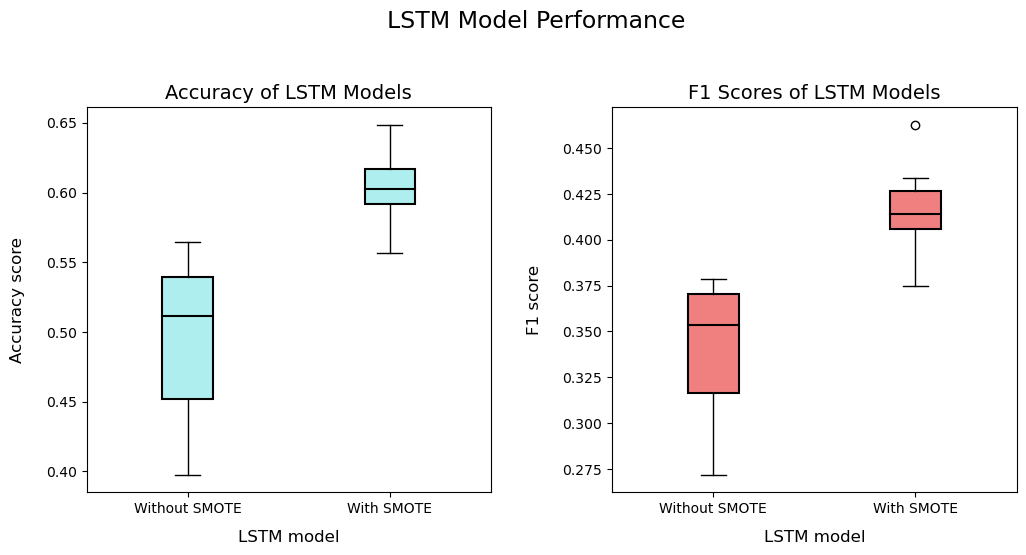

In [41]:
# Create plot for accuracy and F1 boxplots
figs,axes = plt.subplots(1,2,sharex=False,sharey=False,
                         gridspec_kw={'wspace':0.3,
                                     'hspace':0.5},
                         figsize=(12,5))
plt.suptitle("LSTM Model Performance",fontsize=17,y=1.075)

# Plot accuracy scores
lstm_acc_bplot = axes[0].boxplot([lstm_accuracy_scores,sm_lstm_accuracy_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"paleturquoise"},
                    medianprops={"linewidth":1.5})

for median in lstm_acc_bplot["medians"]:
    median.set_color("black")

axes[0].set_title("Accuracy of LSTM Models",fontsize=14,y=1)
axes[0].set_xlabel("LSTM model",fontsize=12,labelpad=10)
axes[0].set_ylabel("Accuracy score",fontsize=12,labelpad=15)

# Plot F1 scores
lstm_f1_bplot = axes[1].boxplot([lstm_f1_scores,sm_lstm_f1_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Without SMOTE","With SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"lightcoral"},
                    medianprops={"linewidth":1.5})

for median in lstm_f1_bplot["medians"]:
    median.set_color("black")

axes[1].set_title("F1 Scores of LSTM Models",fontsize=14,y=1)
axes[1].set_xlabel("LSTM model",fontsize=12,labelpad=10)
axes[1].set_ylabel("F1 score",fontsize=12,labelpad=15)

plt.savefig("lstm_duo_bplot.png")
plt.show()

# Model Comparison

In [42]:
# Create means of accuracy scores and F1 scores per model, with and without SMOTE
nb_acc = np.mean(bayes_accuracy_scores)
nb_acc_smote = np.mean(sm_bayes_accuracy_scores)
nb_f1 = np.mean(bayes_f1_scores)
nb_f1_smote = np.mean(sm_bayes_f1_scores)

xgb_acc = np.mean(xgb_accuracy_scores)
xgb_acc_smote = np.mean(sm_xgb_accuracy_scores)
xgb_f1 = np.mean(xgb_f1_scores)
xgb_f1_smote = np.mean(sm_xgb_f1_scores)

lstm_acc = np.mean(lstm_accuracy_scores)
lstm_acc_smote = np.mean(sm_lstm_accuracy_scores)
lstm_f1 = np.mean(lstm_f1_scores)
lstm_f1_smote = np.mean(sm_lstm_f1_scores)

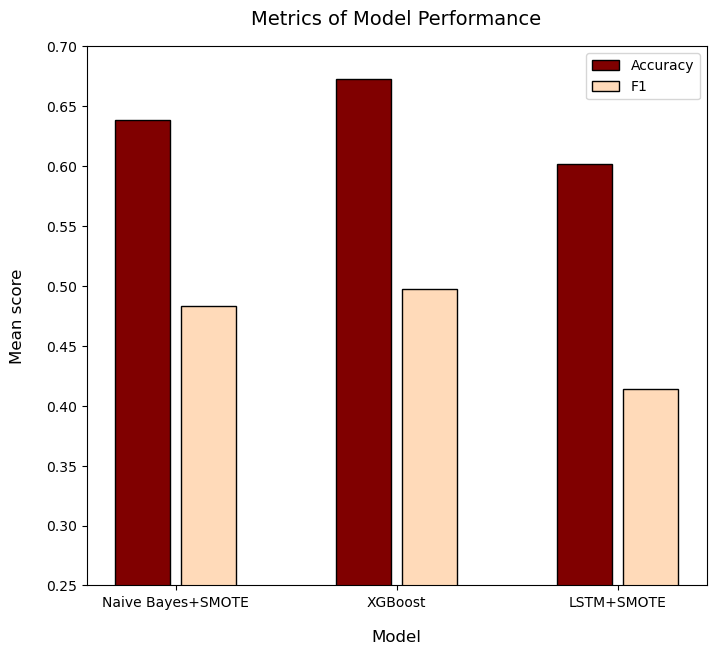

In [43]:
# Create lists of accuracy and F1 scores of best performing version of each model
accuracy_models = [nb_acc_smote,xgb_acc,lstm_acc_smote]
f1_models = [nb_f1_smote,xgb_f1,lstm_f1_smote]

# Create labels
labels = ["Naive Bayes+SMOTE","XGBoost","LSTM+SMOTE"]
x_axis = np.arange(3)

# Plot bar graph of accuracy and F1 scores
fig = plt.figure(figsize=(8,7))
plt.bar(x_axis-0.15,accuracy_models,width=0.25,label="Accuracy",color="maroon",
        edgecolor="black",linewidth=1)
plt.bar(x_axis+0.15,f1_models,width=0.25,label="F1",color="peachpuff",
        edgecolor="black",linewidth=1)
plt.xticks(x_axis,labels)
plt.xlabel("Model",fontsize=12,labelpad=15)
plt.ylabel("Mean score",fontsize=12,labelpad=15)
plt.title("Metrics of Model Performance",fontsize=14,y=1.025)
plt.ylim(0.25,0.7)
plt.legend()

plt.savefig("mean_metrics_3.png")
plt.show()

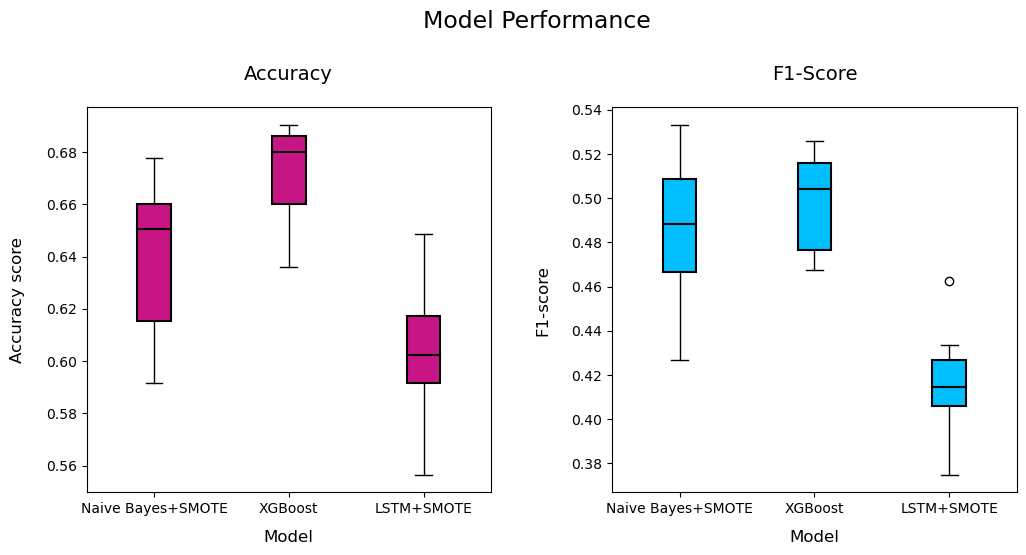

In [44]:
# Create plot for accuracy and F1 boxplots
figs,axes = plt.subplots(1,2,sharex=False,sharey=False,
                         gridspec_kw={'wspace':0.3,
                                     'hspace':0.5},
                         figsize=(12,5))
plt.suptitle("Model Performance",fontsize=17,y=1.075)

# Plot accuracy scores
mod_acc_comp_bplot = axes[0].boxplot([sm_bayes_accuracy_scores,
                            xgb_accuracy_scores,
                            sm_lstm_accuracy_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Naive Bayes+SMOTE","XGBoost","LSTM+SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"mediumvioletred"},
                    medianprops={"linewidth":1.5})

for median in mod_acc_comp_bplot["medians"]:
    median.set_color("black")

axes[0].set_title("Accuracy",fontsize=14,y=1.05)
axes[0].set_xlabel("Model",fontsize=12,labelpad=10)
axes[0].set_ylabel("Accuracy score",fontsize=12,labelpad=15)

# Plot F1 scores
mod_f1_comp_bplot = axes[1].boxplot([sm_bayes_f1_scores,
                            xgb_f1_scores,
                            sm_lstm_f1_scores],
                    widths=0.25,patch_artist=True,
                    labels=["Naive Bayes+SMOTE","XGBoost","LSTM+SMOTE"],
                    boxprops={"linewidth":1.5,
                             "facecolor":"deepskyblue"},
                    medianprops={"linewidth":1.5})

for median in mod_f1_comp_bplot["medians"]:
    median.set_color("black")

axes[1].set_title("F1-Score",fontsize=14,y=1.05)
axes[1].set_xlabel("Model",fontsize=12,labelpad=10)
axes[1].set_ylabel("F1-score",fontsize=12,labelpad=15)

plt.savefig("mod_comp_bplot.png")
plt.show()

In [56]:
# Accuracy scores:

# Conduct Shapiro-Wilk test for normality
print(stats.shapiro(sm_bayes_accuracy_scores))
print(stats.shapiro(xgb_accuracy_scores))
print(stats.shapiro(sm_lstm_accuracy_scores),"\n")

# Conduct levene tests to determine if variances are equal
print(stats.levene(sm_bayes_accuracy_scores,xgb_accuracy_scores,
                   center="mean"))
print(stats.levene(sm_bayes_accuracy_scores,sm_lstm_accuracy_scores,
                   center="mean"))
print(stats.levene(xgb_accuracy_scores,sm_lstm_accuracy_scores,
                   center="mean"))

# Conduct t-tests
print("\nBayes and XGB accuracy:")
nb_xgb_acc_ttest = stats.ttest_ind(sm_bayes_accuracy_scores,xgb_accuracy_scores,
                                    equal_var=False,alternative="two-sided")
print("T-statistic:",nb_xgb_acc_ttest.statistic)
print("P-value:",nb_xgb_acc_ttest.pvalue,"\n")

print("Bayes and LSTM accuracy:")
nb_lstm_acc_ttest = stats.ttest_ind(sm_bayes_accuracy_scores,sm_lstm_accuracy_scores,
                                    equal_var=True,alternative="two-sided")
print("T-statistic:",nb_lstm_acc_ttest.statistic)
print("P-value:",nb_lstm_acc_ttest.pvalue,"\n")

print("XGB and LSTM accuracy:")
lstm_xgb_acc_ttest = stats.ttest_ind(xgb_accuracy_scores,sm_lstm_accuracy_scores,
                                    equal_var=True,alternative="two-sided")
print("T-statistic:",lstm_xgb_acc_ttest.statistic)
print("P-value:",lstm_xgb_acc_ttest.pvalue,"\n")


# F1 scores:

# Conduct Shapiro-Wilk test for normality
print(stats.shapiro(sm_bayes_f1_scores))
print(stats.shapiro(xgb_f1_scores))
print(stats.shapiro(sm_lstm_f1_scores),"\n")

# Conduct levene tests to determine if variances are equal
print(stats.levene(sm_bayes_f1_scores,xgb_f1_scores,
                   center="mean"))
print(stats.levene(sm_bayes_f1_scores,sm_lstm_f1_scores,
                   center="mean"))
print(stats.levene(xgb_f1_scores,sm_lstm_f1_scores,
                   center="mean"))

# Conduct t-tests
print("\nBayes and XGB F1:")
nb_xgb_f1_ttest = stats.ttest_ind(sm_bayes_f1_scores,xgb_f1_scores,
                                    equal_var=True,alternative="two-sided")
print("T-statistic:",nb_xgb_f1_ttest.statistic)
print("P-value:",nb_xgb_f1_ttest.pvalue,"\n")

print("Bayes and LSTM F1:")
nb_lstm_f1_ttest = stats.ttest_ind(sm_bayes_f1_scores,sm_lstm_f1_scores,
                                    equal_var=True,alternative="two-sided")
print("T-statistic:",nb_lstm_f1_ttest.statistic)
print("P-value:",nb_lstm_f1_ttest.pvalue,"\n")

print("XGB and LSTM F1:")
lstm_xgb_f1_ttest = stats.ttest_ind(xgb_f1_scores,sm_lstm_f1_scores,
                                    equal_var=True,alternative="two-sided")
print("T-statistic:",lstm_xgb_f1_ttest.statistic)
print("P-value:",lstm_xgb_f1_ttest.pvalue,"\n")

ShapiroResult(statistic=0.9065627455711365, pvalue=0.25820520520210266)
ShapiroResult(statistic=0.8641034960746765, pvalue=0.08528277277946472)
ShapiroResult(statistic=0.973363995552063, pvalue=0.920162558555603) 

LeveneResult(statistic=5.821134295515718, pvalue=0.02672044126938754)
LeveneResult(statistic=0.5304371787724723, pvalue=0.4757921801329428)
LeveneResult(statistic=0.9677489872378681, pvalue=0.3382813688823269)

Bayes and XGB accuracy:
T-statistic: -3.170665785074803
P-value: 0.00644454331906562 

Bayes and LSTM accuracy:
T-statistic: 2.8360807935781573
P-value: 0.010954781620536626 

XGB and LSTM accuracy:
T-statistic: 6.742549622225337
P-value: 2.554418563655734e-06 

ShapiroResult(statistic=0.937434732913971, pvalue=0.5248382687568665)
ShapiroResult(statistic=0.8957343697547913, pvalue=0.19657103717327118)
ShapiroResult(statistic=0.9417388439178467, pvalue=0.5725197792053223) 

LeveneResult(statistic=1.9711177079054156, pvalue=0.17734794863099007)
LeveneResult(statistic=1.